In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import  DataLoader, Dataset
import math
import torch.optim as optim
import requests
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
import datetime
import tqdm
import scipy.io
import shutil
import bottleneck as bn
import copy
from IPython.display import clear_output

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)
%cd '/content/drive/MyDrive/RS20201'

cuda
/content/drive/.shortcut-targets-by-id/1LR5Mn4Up1P_WF_xQcB6Bq2ucIFyIKXhN/RS20201


Split data, don't do it again !


In [ ]:
with open("user_song_data_big.txt", 'r') as f:
    user_song_data = [line.split('<fff>') for line in f.read().splitlines()]

min_user_react = 100
min_song_react = 300

# user
train = []
new_users, new_songs = [], []
mem = []
user_song_data = sorted(user_song_data, key=lambda x: x[0])
for i in range(len(user_song_data) - 1):
    user, item, rating = user_song_data[i][0], user_song_data[i][1], user_song_data[i][2]
    mem.append([user, item, rating])
    if user_song_data[i][0] != user_song_data[i + 1][0]:
        if len(mem) >= min_user_react:
            train += mem
            print(len(mem))
        elif len(mem) >= 90:
            new_users += mem
        mem = []

mem.append([user_song_data[-1][0], user_song_data[-1][1], user_song_data[-1][2]])
if len(mem) >= min_user_react:
    train += mem
    print(len(mem))
elif len(mem) >= 90:
    new_users += mem

# song
user_song_data = sorted(train, key=lambda x: x[1])
train = []
mem = []
for i in range(len(user_song_data) - 1):
    user, item, rating = user_song_data[i][0], user_song_data[i][1], user_song_data[i][2]
    mem.append([user, item, rating])
    if user_song_data[i][1] != user_song_data[i + 1][1]:
        if len(mem) >= min_song_react:
            train += mem
            print(len(mem))
        elif len(mem) >= 250:
            new_songs += mem
        mem = []

mem.append([user_song_data[-1][0], user_song_data[-1][1], user_song_data[-1][2]])
if len(mem) >= min_song_react:
    train += mem
    print(len(mem))
elif len(mem) >= 250:
    new_songs += mem
    
mem = []

train = ['<fff>'.join(line) for line in train]
new_users = ['<fff>'.join(line) for line in new_users]
new_songs = ['<fff>'.join(line) for line in new_songs]
print('train size:', len(train))
with open('user_song_data_100_300.txt', 'w') as f:
    f.write('\n'.join(train))

with open('new_user_90.txt', 'w') as f:
    f.write('\n'.join(new_users))
    
with open('new_song_250.txt', 'w') as f:
    f.write('\n'.join(new_songs))

In [ ]:
with open('user_song_data_100_300.txt', 'r') as f:
    data = [line.split('<fff>') for line in f.read().splitlines()]

data = sorted(data, key=lambda x: x[0])

np.random.seed(1999)

# create train/validation/test users

train = []
valid_tr, valid_te = [], []
test_tr, test_te = [], []
mem_tr, mem_te = [], []
for i in range(len(data) - 1):
    u, s, r = data[i][0], data[i][1], data[i][2]
    choice = np.random.choice(['train', 'test'], p=(0.8, 0.2))
    if choice == 'train':
        mem_tr.append('<fff>'.join([u, s, r]))
    else:
        mem_te.append('<fff>'.join([u, s, r]))

    if data[i][0] != data[i+1][0]:
        choice = np.random.choice(['train', 'test', 'valid'], p=(0.7, 0.15, 0.15))
        if choice == 'train':
            train.append(' '.join(mem_tr+mem_te))
        elif choice == 'valid':
            valid_tr.append(' '.join(mem_tr))
            valid_te.append(' '.join(mem_te))
        elif choice == 'test':
            test_tr.append(' '.join(mem_tr))
            test_te.append(' '.join(mem_te))
        mem_tr, mem_te = [], []

u, s, r = data[-1][0], data[-1][1], data[-1][2]
choice = np.random.choice(['train', 'test'], p=(0.8, 0.2))
if choice == 'train':
    mem_tr.append('<fff>'.join([u, s, r]))
else:
    mem_te.append('<fff>'.join([u, s, r]))

choice = np.random.choice(['train', 'test', 'valid'], p=(0.7, 0.15, 0.15))
if choice == 'train':
    train.append(' '.join(mem_tr+mem_te))
elif choice == 'valid':
    valid_tr.append(' '.join(mem_tr))
    valid_te.append(' '.join(mem_te))
elif choice == 'test':
    test_tr.append(' '.join(mem_tr))
    test_te.append(' '.join(mem_te))

mem_tr, mem_te = [], []
data = []

with open('train_100_300.txt', 'w') as f:
    f.write('\n'.join(train))
with open('valid_tr_100_300.txt', 'w') as f:
    f.write('\n'.join(valid_tr))
with open('valid_te_100_300.txt', 'w') as f:
    f.write('\n'.join(valid_te))
with open('test_tr_100_300.txt', 'w') as f:
    f.write('\n'.join(test_tr))
with open('test_te_100_300.txt', 'w') as f:
    f.write('\n'.join(test_te))

print(len(train))
print(len(test_tr))
print(len(valid_tr))
print(len(test_te))
print(len(valid_te))

In [ ]:
with open('data/new_user_90.txt', 'r') as f:
    new_user = [line.split('<fff>') for line in f.read().splitlines()]

new_user = sorted(new_user, key=lambda x:x[0])
test_new_user = []
mem = []
for i in range(len(new_user) - 1):
    user, item, rating = new_user[i][0], new_user[i][1], new_user[i][2]
    if item in stoi:
        mem.append('<fff>'.join([user, item, rating]))
    if new_user[i][0] != new_user[i + 1][0]:
        if len(mem) >= 50:
            test_new_user.append(' '.join(mem))
            # print(len(mem))
        mem = []
if new_user[-1][1] in stoi:
    mem.append('<fff>'.join([new_user[-1][0], new_user[-1][1], new_user[-1][2]]))
if len(mem) >= 50:
    test_new_user.append(' '.join(mem))
    # print(len(mem))

with open('data/test_new_user.txt', 'w') as f:
    f.write('\n'.join(test_new_user))
print(len(test_new_user))

2524


In [ ]:
with open('data/new_user_90.txt', 'r') as f:
    new_user = [line.split('<fff>') for line in f.read().splitlines()]

new_user = sorted(new_user, key=lambda x:x[0])
test_new_user = []
mem = []
for i in range(len(new_user) - 1):
    user, item, rating = new_user[i][0], new_user[i][1], new_user[i][2]
    if item in stoi:
        mem.append('<fff>'.join([user, item, rating]))
    if new_user[i][0] != new_user[i + 1][0]:
        if len(mem) >= 50:
            test_new_user.append(' '.join(mem))
            # print(len(mem))
        mem = []
if new_user[-1][1] in stoi:
    mem.append('<fff>'.join([new_user[-1][0], new_user[-1][1], new_user[-1][2]]))
if len(mem) >= 50:
    test_new_user.append(' '.join(mem))
    # print(len(mem))

with open('data/test_new_user.txt', 'w') as f:
    f.write('\n'.join(test_new_user))
print(len(test_new_user))

In [ ]:
with open('/content/drive/MyDrive/RS20201/data/user_song_data_100_300.txt', 'r') as f:
    songs = [line.split('<fff>')[1] for line in f.read().splitlines()]

songs = list(set(songs))
with open('data/unique_song_100_300.txt', 'w') as f:
    f.write('\n'.join(['{}:{}'.format(song_id, idx) for idx, song_id in enumerate(songs)]))

DataSet

In [ ]:
num_songs = 19661
path = '_100_300'

with open('data/unique_song%s.txt'%path, 'r') as f:
    stoi = dict([(line.split(':')[0], int(line.split(':')[1])) for line in f.read().splitlines()])
num_songs = len(stoi.keys())
print(num_songs)

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

class MSD(Dataset):

    def __init__(self, split='train', conditioned_on=None, upper=-1):

        super(MSD, self).__init__()
        self.split = split
        self.train = []
        with open('data/train%s.txt'%path, 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = sigmoid(int(r))
                arr = csr_matrix(arr)
                self.train.append(arr)

        self.valid_tr, self.valid_te = [], []
        with open('data/valid_tr%s.txt'%path, 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = sigmoid(int(r))
                arr = csr_matrix(arr)
                self.valid_tr.append(arr)
        with open('data/valid_te%s.txt'%path, 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = sigmoid(int(r))
                arr = csr_matrix(arr)
                self.valid_te.append(arr)

        self.test_tr, self.test_te = [], []
        with open('data/test_tr%s.txt'%path, 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = sigmoid(int(r))
                arr = csr_matrix(arr)
                self.test_tr.append(arr)
        with open('data/test_te%s.txt'%path, 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = sigmoid(int(r))
                arr = csr_matrix(arr)
                self.test_te.append(arr)
       
        
        self.n_tr = len(self.train)
        self.n_te = len(self.test_tr)
        self.n_va = len(self.valid_tr)

    def __len__(self):
        if self.split == 'train':
            return self.n_tr
        elif self.split == 'test':
            return self.n_te
        else:
            return self.n_va

    def __getitem__(self, index):
        if self.split == 'train':
            tr= self.train[index].toarray()[0]
            return tr
        elif self.split == 'test':
            tr= self.test_tr[index].toarray()[0]
            te = self.test_te[index].toarray()[0]
            return tr, te
        else:
            tr= self.valid_tr[index].toarray()[0]
            te = self.valid_te[index].toarray()[0]
            return tr, te

data = MSD()

3231


Model and eval function

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


# borrowed from https://github.com/dawenl/vae_cf/blob/master/VAE_ML20M_WWW2018.ipynb
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk] * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(int(n), k)]).sum() for n in heldout_batch.sum(axis=1)])
    # print(DCG, IDCG)
    return DCG / IDCG

def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1) # top k
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0)
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

class Encoder(nn.Module):
    def __init__(self, num_songs, dropout_p=0.5):
        super(Encoder, self).__init__()
        self.num_songs = num_songs

        self.dropout = nn.Dropout(p=dropout_p, inplace=False)
        self.linear_1 = nn.Linear(num_songs, 600, bias=True)
        self.linear_2 = nn.Linear(600, 200 * 2, bias=True)
        self.tanh = nn.Tanh()

        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear_1(x)
        x = self.tanh(x)
        x = self.linear_2(x)
        mu_q, logvar_q = torch.chunk(x, chunks=2, dim=1)
        return mu_q, logvar_q


class Decoder(nn.Module):
    def __init__(self, num_songs):
        super(Decoder, self).__init__()
        self.num_songs = num_songs

        self.linear_1 = nn.Linear(200, 600, bias=True)
        self.linear_2 = nn.Linear(600, num_songs, bias=True)
        self.tanh = nn.Tanh()

        for module_name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.normal_(0.0, 0.001)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.tanh(x)
        x = self.linear_2(x)
        return x

class MultiVAE(nn.Module):
    def __init__(self, name, num_songs, cuda2=True, weight_decay=0.0, dropout_p=0.5):
        super(MultiVAE, self).__init__()
        self.cuda2 = cuda2
        self.name = name
        self.weight_decay = weight_decay
        self.num_songs = num_songs

        self.encoder = Encoder(num_songs=num_songs, dropout_p=dropout_p)
        self.decoder = Decoder(num_songs=num_songs)

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)

        mu_q, logvar_q = self.encoder.forward(x)
        std_q = torch.exp(0.5 * logvar_q)
        KL = torch.mean(torch.sum(0.5 * (-logvar_q + torch.exp(logvar_q) + mu_q ** 2 - 1), dim=1))
        epsilon = torch.randn_like(std_q, requires_grad=False)
        if True:
            if self.training:
                sampled_z = mu_q + epsilon * std_q
            else:
                sampled_z = mu_q
        else:
            sampled_z = mu_q + epsilon * std_q

        logits = self.decoder.forward(sampled_z)

        return logits, KL, mu_q, std_q, epsilon, sampled_z

    def get_l2_reg(self):
        l2_reg = Variable(torch.FloatTensor(1), requires_grad=True)
        if self.weight_decay > 0:
            for k, m in self.state_dict().items():
                if k.endswith('.weight'):
                    l2_reg = l2_reg + torch.norm(m, p=2) ** 2
        if self.cuda2:
            l2_reg = l2_reg.cuda()
        return self.weight_decay * l2_reg[0]


Train model

In [ ]:
class Trainer(object):

    def __init__(self, model, data=None, batch_size=500,
                 interval_validate=1, n_epochs=100,
                 start_step=0, start_epoch=0, anneal_cap=0.2):

        self.model = model.to(device)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[100, 150], gamma=0.1, last_epoch=-1)
        self.data = data
        self.data.split = 'train'
        self.batch_size = batch_size
        self.data_loader = DataLoader(self.data, batch_size=self.batch_size, shuffle=True)
        self.timestamp_start = datetime.datetime.now()
        self.n_epochs = n_epochs
        self.start_step = start_step
        self.step = start_step
        self.epoch = start_epoch
        self.total_anneal_steps = len(self.data_loader)*self.n_epochs
        self.anneal_cap = anneal_cap
        self.best_beta = 0.2
        self.n20_max_va, self.n100_max_va, self.r20_max_va, self.r50_max_va = 0, 0, 0, 0
        self.n20_max_te, self.n100_max_te, self.r20_max_te, self.r50_max_te = 0, 0, 0, 0
        self.n20_epochs, self.n100_epochs, self.r20_epochs, self.r50_epochs = [], [], [], []


    def validate(self, cmd="valid"):
        assert cmd in ['valid', 'test']
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        self.model.eval()
        end = time.time()
        n20_list, n100_list, r20_list, r50_list = [], [], [], []
        self.data.split = cmd
        step_counter = 0
        for batch_idx, (data_tr, data_te) in enumerate(self.data_loader):
            step_counter = step_counter + 1
            mask_tr = (data_tr!=0)*1.0
            mask_tr = mask_tr.to(device).float()
            mask_tr = Variable(mask_tr)
            mask_te = (data_te!=0)*1.0
            data_tr = data_tr.to(device).float()
            data_tr = Variable(data_tr)
            data_time.update(time.time() - end)
            end = time.time()
            with torch.no_grad():
                if self.model.__class__.__name__ == 'MultiVAE':
                    logits, KL, mu_q, std_q, epsilon, sampled_z = self.model.forward(mask_tr)
                else:
                    logits = self.model.forward(mask_tr)
                pred_val = logits.cpu().detach().numpy()
                pred_val[mask_tr.cpu().detach().numpy().nonzero()] = -np.inf

                n20_list.append(NDCG_binary_at_k_batch(pred_val, mask_te.cpu().numpy(), k=20))
                n100_list.append(NDCG_binary_at_k_batch(pred_val, mask_te.cpu().numpy(), k=100))
                r20_list.append(Recall_at_k_batch(pred_val, mask_te.cpu().numpy(), k=20))
                r50_list.append(Recall_at_k_batch(pred_val, mask_te.cpu().numpy(), k=50))

        n20_list = bn.nanmean(np.concatenate(n20_list, axis=0))
        n100_list = bn.nanmean(np.concatenate(n100_list, axis=0))
        r20_list = bn.nanmean(np.concatenate(r20_list, axis=0))
        r50_list = bn.nanmean(np.concatenate(r50_list, axis=0))
        self.n20_epochs.append(n20_list)
        self.n100_epochs.append(n100_list)
        self.r20_epochs.append(r20_list)
        self.r50_epochs.append(r50_list)
        
        if cmd == 'valid':
            self.n20_max_va = max(self.n20_max_va, n20_list)
            if self.n100_max_va < n100_list:
                self.n100_max_va = n100_list
                torch.save(self.model.state_dict(), '/content/drive/MyDrive/RS20201/%s.pt'%self.model.name)
                self.best_beta = 1. * self.step / self.total_anneal_steps
            self.r20_max_va = max(self.r20_max_va, r20_list)
            self.r50_max_va = max(self.r50_max_va, r50_list)
            max_metrics = "{}, epoch {}, step {}, best beta {}, max NDCG@20 {:.5f}, max NDCG@100 {:.5f}, max Recall@20 {:.5f}, max Recall@50 {:.5f}".format(cmd, self.epoch, self.step, self.best_beta, self.n20_max_va, self.n100_max_va, self.r20_max_va, self.r50_max_va)

        else:
            self.n20_max_te = max(self.n20_max_te, n20_list)
            if self.n100_max_te < n100_list:
                self.n100_max_te = n100_list
                # torch.save(self.model.state_dict(), '/content/drive/MyDrive/RS20201/%s.pt'%self.model.name)
            self.r20_max_te = max(self.r20_max_te, r20_list)
            self.r50_max_te = max(self.r50_max_te, r50_list)
            max_metrics = "{}, epoch {}, step {}, best beta {}, max NDCG@20 {:.5f}, max NDCG@100 {:.5f}, max Recall@20 {:.5f}, max Recall@50 {:.5f}".format(cmd, self.epoch, self.step, self.best_beta, self.n20_max_te, self.n100_max_te, self.r20_max_te, self.r50_max_te)

        metrics = []
        metrics.append(max_metrics)
        metrics.append("NDCG@20 {:.5f}".format(n20_list))
        metrics.append("NDCG@100 {:.5f}".format(n100_list))
        metrics.append("Recall@20 {:.5f}".format(r20_list))
        metrics.append("Recall@50 {:.5f}".format(r50_list))
        print('\n' + ",".join(metrics))
        self.model.train()


    def train_epoch(self):
        cmd = "train"
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        self.model.train()
        end = time.time()
        self.data.split = cmd
        for batch_idx, data_tr in enumerate(self.data_loader):
            self.step += 1
            mask_tr = (data_tr!=0)*1.0
            mask_tr = mask_tr.to(device).float()
            mask_tr = Variable(mask_tr)
            data_tr = data_tr.to(device).float()
            data_tr = Variable(data_tr)
            data_time.update(time.time() - end)
            end = time.time()
            if self.model.__class__.__name__ == 'MultiVAE':
                logits, KL, mu_q, std_q, epsilon, sampled_z = self.model.forward(mask_tr)
            else:
                logits = self.model.forward(mask_tr)

            log_softmax_var = F.log_softmax(logits, dim=1)
            neg_ll = - torch.mean(torch.sum(log_softmax_var * data_tr, dim=1))
            l2_reg = self.model.get_l2_reg()

            if self.model.__class__.__name__ == 'MultiVAE':
                if self.total_anneal_steps > 0:
                    self.anneal = min(self.anneal_cap, 1. * self.step / self.total_anneal_steps)
                else:
                    self.anneal = self.anneal_cap

                loss = neg_ll + self.anneal * KL + l2_reg
            else:
                loss = neg_ll + l2_reg

            # backprop
            self.model.zero_grad()
            loss.backward()
            self.optim.step()

    def train(self):
        for epoch in tqdm.trange(0, self.n_epochs, desc='Train', ncols=80):
            self.epoch = epoch
            self.train_epoch()
            self.lr_scheduler.step()
            self.validate(cmd='valid')

implicit model

In [ ]:
torch.manual_seed(0)

model = MultiVAE(name='VAE_100_300_implicit', num_songs=num_songs)
trainer = Trainer(model, data=data, anneal_cap=0.2)
trainer.train()
trainer.validate(cmd='test')


Train:   0%|                                            | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide

Train:   1%|▎                                   | 1/100 [00:03<05:16,  3.19s/it]


valid, epoch 0, step 50, best beta 0.01, max NDCG@20 0.10234, max NDCG@100 0.16034, max Recall@20 0.10534, max Recall@50 0.17128,NDCG@20 0.10234,NDCG@100 0.16034,Recall@20 0.10534,Recall@50 0.17128



Train:   2%|▋                                   | 2/100 [00:06<05:11,  3.18s/it]


valid, epoch 1, step 100, best beta 0.02, max NDCG@20 0.14933, max NDCG@100 0.22593, max Recall@20 0.15688, max Recall@50 0.25018,NDCG@20 0.14933,NDCG@100 0.22593,Recall@20 0.15688,Recall@50 0.25018



Train:   3%|█                                   | 3/100 [00:09<05:08,  3.18s/it]


valid, epoch 2, step 150, best beta 0.03, max NDCG@20 0.18768, max NDCG@100 0.27101, max Recall@20 0.19486, max Recall@50 0.29529,NDCG@20 0.18768,NDCG@100 0.27101,Recall@20 0.19486,Recall@50 0.29529



Train:   4%|█▍                                  | 4/100 [00:12<05:04,  3.17s/it]


valid, epoch 3, step 200, best beta 0.04, max NDCG@20 0.21769, max NDCG@100 0.30466, max Recall@20 0.22090, max Recall@50 0.32981,NDCG@20 0.21769,NDCG@100 0.30466,Recall@20 0.22090,Recall@50 0.32981



Train:   5%|█▊                                  | 5/100 [00:15<05:01,  3.18s/it]


valid, epoch 4, step 250, best beta 0.05, max NDCG@20 0.23785, max NDCG@100 0.32583, max Recall@20 0.24251, max Recall@50 0.35329,NDCG@20 0.23785,NDCG@100 0.32583,Recall@20 0.24251,Recall@50 0.35329



Train:   6%|██▏                                 | 6/100 [00:19<04:58,  3.18s/it]


valid, epoch 5, step 300, best beta 0.06, max NDCG@20 0.25454, max NDCG@100 0.34335, max Recall@20 0.25858, max Recall@50 0.36932,NDCG@20 0.25454,NDCG@100 0.34335,Recall@20 0.25858,Recall@50 0.36932



Train:   7%|██▌                                 | 7/100 [00:22<04:55,  3.17s/it]


valid, epoch 6, step 350, best beta 0.07, max NDCG@20 0.26218, max NDCG@100 0.35241, max Recall@20 0.26730, max Recall@50 0.38056,NDCG@20 0.26218,NDCG@100 0.35241,Recall@20 0.26730,Recall@50 0.38056



Train:   8%|██▉                                 | 8/100 [00:25<04:51,  3.17s/it]


valid, epoch 7, step 400, best beta 0.08, max NDCG@20 0.27166, max NDCG@100 0.36235, max Recall@20 0.27564, max Recall@50 0.39069,NDCG@20 0.27166,NDCG@100 0.36235,Recall@20 0.27564,Recall@50 0.39069



Train:   9%|███▏                                | 9/100 [00:28<04:50,  3.19s/it]


valid, epoch 8, step 450, best beta 0.09, max NDCG@20 0.27608, max NDCG@100 0.36633, max Recall@20 0.28165, max Recall@50 0.39693,NDCG@20 0.27608,NDCG@100 0.36633,Recall@20 0.28165,Recall@50 0.39693



Train:  10%|███▌                               | 10/100 [00:31<04:46,  3.18s/it]


valid, epoch 9, step 500, best beta 0.1, max NDCG@20 0.27907, max NDCG@100 0.37048, max Recall@20 0.28409, max Recall@50 0.40006,NDCG@20 0.27907,NDCG@100 0.37048,Recall@20 0.28409,Recall@50 0.40006



Train:  11%|███▊                               | 11/100 [00:34<04:42,  3.18s/it]


valid, epoch 10, step 550, best beta 0.11, max NDCG@20 0.28356, max NDCG@100 0.37454, max Recall@20 0.28874, max Recall@50 0.40410,NDCG@20 0.28356,NDCG@100 0.37454,Recall@20 0.28874,Recall@50 0.40410



Train:  12%|████▏                              | 12/100 [00:38<04:41,  3.19s/it]


valid, epoch 11, step 600, best beta 0.12, max NDCG@20 0.28614, max NDCG@100 0.37726, max Recall@20 0.29080, max Recall@50 0.40585,NDCG@20 0.28614,NDCG@100 0.37726,Recall@20 0.29080,Recall@50 0.40585



Train:  13%|████▌                              | 13/100 [00:41<04:36,  3.18s/it]


valid, epoch 12, step 650, best beta 0.13, max NDCG@20 0.28793, max NDCG@100 0.37884, max Recall@20 0.29300, max Recall@50 0.40849,NDCG@20 0.28793,NDCG@100 0.37884,Recall@20 0.29300,Recall@50 0.40849



Train:  14%|████▉                              | 14/100 [00:44<04:32,  3.17s/it]


valid, epoch 13, step 700, best beta 0.14, max NDCG@20 0.29215, max NDCG@100 0.38286, max Recall@20 0.29678, max Recall@50 0.41079,NDCG@20 0.29215,NDCG@100 0.38286,Recall@20 0.29678,Recall@50 0.41079



Train:  15%|█████▎                             | 15/100 [00:47<04:29,  3.17s/it]


valid, epoch 14, step 750, best beta 0.15, max NDCG@20 0.29422, max NDCG@100 0.38518, max Recall@20 0.29809, max Recall@50 0.41278,NDCG@20 0.29422,NDCG@100 0.38518,Recall@20 0.29809,Recall@50 0.41278



Train:  16%|█████▌                             | 16/100 [00:50<04:23,  3.13s/it]


valid, epoch 15, step 800, best beta 0.15, max NDCG@20 0.29422, max NDCG@100 0.38518, max Recall@20 0.29809, max Recall@50 0.41348,NDCG@20 0.29415,NDCG@100 0.38517,Recall@20 0.29737,Recall@50 0.41348



Train:  17%|█████▉                             | 17/100 [00:53<04:21,  3.15s/it]


valid, epoch 16, step 850, best beta 0.17, max NDCG@20 0.29640, max NDCG@100 0.38733, max Recall@20 0.29896, max Recall@50 0.41569,NDCG@20 0.29640,NDCG@100 0.38733,Recall@20 0.29896,Recall@50 0.41569



Train:  18%|██████▎                            | 18/100 [00:57<04:17,  3.15s/it]


valid, epoch 17, step 900, best beta 0.18, max NDCG@20 0.29729, max NDCG@100 0.38791, max Recall@20 0.30063, max Recall@50 0.41630,NDCG@20 0.29729,NDCG@100 0.38791,Recall@20 0.30063,Recall@50 0.41630



Train:  19%|██████▋                            | 19/100 [01:00<04:15,  3.15s/it]


valid, epoch 18, step 950, best beta 0.19, max NDCG@20 0.29816, max NDCG@100 0.38908, max Recall@20 0.30126, max Recall@50 0.41651,NDCG@20 0.29816,NDCG@100 0.38908,Recall@20 0.30126,Recall@50 0.41651



Train:  20%|███████                            | 20/100 [01:03<04:11,  3.15s/it]


valid, epoch 19, step 1000, best beta 0.2, max NDCG@20 0.29896, max NDCG@100 0.38948, max Recall@20 0.30356, max Recall@50 0.41801,NDCG@20 0.29896,NDCG@100 0.38948,Recall@20 0.30356,Recall@50 0.41801



Train:  21%|███████▎                           | 21/100 [01:06<04:09,  3.16s/it]


valid, epoch 20, step 1050, best beta 0.21, max NDCG@20 0.29896, max NDCG@100 0.38951, max Recall@20 0.30356, max Recall@50 0.41950,NDCG@20 0.29858,NDCG@100 0.38951,Recall@20 0.30332,Recall@50 0.41950



Train:  22%|███████▋                           | 22/100 [01:09<04:06,  3.16s/it]


valid, epoch 21, step 1100, best beta 0.22, max NDCG@20 0.29896, max NDCG@100 0.38990, max Recall@20 0.30356, max Recall@50 0.41950,NDCG@20 0.29872,NDCG@100 0.38990,Recall@20 0.30257,Recall@50 0.41811



Train:  23%|████████                           | 23/100 [01:12<04:01,  3.14s/it]


valid, epoch 22, step 1150, best beta 0.23, max NDCG@20 0.29930, max NDCG@100 0.39121, max Recall@20 0.30433, max Recall@50 0.42086,NDCG@20 0.29930,NDCG@100 0.39121,Recall@20 0.30433,Recall@50 0.42086



Train:  24%|████████▍                          | 24/100 [01:15<03:59,  3.15s/it]


valid, epoch 23, step 1200, best beta 0.24, max NDCG@20 0.30259, max NDCG@100 0.39347, max Recall@20 0.30627, max Recall@50 0.42094,NDCG@20 0.30259,NDCG@100 0.39347,Recall@20 0.30627,Recall@50 0.42094



Train:  25%|████████▊                          | 25/100 [01:19<03:55,  3.14s/it]


valid, epoch 24, step 1250, best beta 0.25, max NDCG@20 0.30259, max NDCG@100 0.39351, max Recall@20 0.30627, max Recall@50 0.42182,NDCG@20 0.30109,NDCG@100 0.39351,Recall@20 0.30417,Recall@50 0.42182



Train:  26%|█████████                          | 26/100 [01:22<03:51,  3.13s/it]


valid, epoch 25, step 1300, best beta 0.26, max NDCG@20 0.30259, max NDCG@100 0.39396, max Recall@20 0.30723, max Recall@50 0.42314,NDCG@20 0.30253,NDCG@100 0.39396,Recall@20 0.30723,Recall@50 0.42314



Train:  27%|█████████▍                         | 27/100 [01:25<03:48,  3.14s/it]


valid, epoch 26, step 1350, best beta 0.27, max NDCG@20 0.30379, max NDCG@100 0.39536, max Recall@20 0.30770, max Recall@50 0.42335,NDCG@20 0.30379,NDCG@100 0.39536,Recall@20 0.30770,Recall@50 0.42335



Train:  28%|█████████▊                         | 28/100 [01:28<03:45,  3.13s/it]


valid, epoch 27, step 1400, best beta 0.27, max NDCG@20 0.30379, max NDCG@100 0.39536, max Recall@20 0.30770, max Recall@50 0.42433,NDCG@20 0.30292,NDCG@100 0.39459,Recall@20 0.30714,Recall@50 0.42433



Train:  29%|██████████▏                        | 29/100 [01:31<03:40,  3.10s/it]


valid, epoch 28, step 1450, best beta 0.27, max NDCG@20 0.30379, max NDCG@100 0.39536, max Recall@20 0.30770, max Recall@50 0.42526,NDCG@20 0.30329,NDCG@100 0.39492,Recall@20 0.30747,Recall@50 0.42526



Train:  30%|██████████▌                        | 30/100 [01:34<03:37,  3.11s/it]


valid, epoch 29, step 1500, best beta 0.3, max NDCG@20 0.30379, max NDCG@100 0.39536, max Recall@20 0.30770, max Recall@50 0.42611,NDCG@20 0.30303,NDCG@100 0.39536,Recall@20 0.30764,Recall@50 0.42611



Train:  31%|██████████▊                        | 31/100 [01:37<03:34,  3.12s/it]


valid, epoch 30, step 1550, best beta 0.31, max NDCG@20 0.30490, max NDCG@100 0.39626, max Recall@20 0.31020, max Recall@50 0.42611,NDCG@20 0.30490,NDCG@100 0.39626,Recall@20 0.31020,Recall@50 0.42546



Train:  32%|███████████▏                       | 32/100 [01:40<03:32,  3.12s/it]


valid, epoch 31, step 1600, best beta 0.32, max NDCG@20 0.30543, max NDCG@100 0.39681, max Recall@20 0.31020, max Recall@50 0.42646,NDCG@20 0.30543,NDCG@100 0.39681,Recall@20 0.30950,Recall@50 0.42646



Train:  33%|███████████▌                       | 33/100 [01:43<03:27,  3.10s/it]


valid, epoch 32, step 1650, best beta 0.32, max NDCG@20 0.30543, max NDCG@100 0.39681, max Recall@20 0.31020, max Recall@50 0.42648,NDCG@20 0.30480,NDCG@100 0.39660,Recall@20 0.30910,Recall@50 0.42648



Train:  34%|███████████▉                       | 34/100 [01:47<03:25,  3.12s/it]


valid, epoch 33, step 1700, best beta 0.34, max NDCG@20 0.30543, max NDCG@100 0.39693, max Recall@20 0.31020, max Recall@50 0.42774,NDCG@20 0.30492,NDCG@100 0.39693,Recall@20 0.30975,Recall@50 0.42774



Train:  35%|████████████▎                      | 35/100 [01:50<03:22,  3.11s/it]


valid, epoch 34, step 1750, best beta 0.35, max NDCG@20 0.30577, max NDCG@100 0.39805, max Recall@20 0.31020, max Recall@50 0.42862,NDCG@20 0.30577,NDCG@100 0.39805,Recall@20 0.30996,Recall@50 0.42862



Train:  36%|████████████▌                      | 36/100 [01:53<03:17,  3.09s/it]


valid, epoch 35, step 1800, best beta 0.35, max NDCG@20 0.30577, max NDCG@100 0.39805, max Recall@20 0.31020, max Recall@50 0.42862,NDCG@20 0.30459,NDCG@100 0.39699,Recall@20 0.30952,Recall@50 0.42775



Train:  37%|████████████▉                      | 37/100 [01:56<03:13,  3.07s/it]


valid, epoch 36, step 1850, best beta 0.35, max NDCG@20 0.30577, max NDCG@100 0.39805, max Recall@20 0.31020, max Recall@50 0.42862,NDCG@20 0.30499,NDCG@100 0.39727,Recall@20 0.31003,Recall@50 0.42631



Train:  38%|█████████████▎                     | 38/100 [01:59<03:11,  3.09s/it]


valid, epoch 37, step 1900, best beta 0.38, max NDCG@20 0.30820, max NDCG@100 0.40077, max Recall@20 0.31176, max Recall@50 0.42889,NDCG@20 0.30820,NDCG@100 0.40077,Recall@20 0.31176,Recall@50 0.42889



Train:  39%|█████████████▋                     | 39/100 [02:02<03:07,  3.07s/it]


valid, epoch 38, step 1950, best beta 0.38, max NDCG@20 0.30820, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.42989,NDCG@20 0.30665,NDCG@100 0.39841,Recall@20 0.31287,Recall@50 0.42989



Train:  40%|██████████████                     | 40/100 [02:05<03:03,  3.07s/it]


valid, epoch 39, step 2000, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.42989,NDCG@20 0.30868,NDCG@100 0.40041,Recall@20 0.31265,Recall@50 0.42937



Train:  41%|██████████████▎                    | 41/100 [02:08<03:00,  3.05s/it]


valid, epoch 40, step 2050, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.42989,NDCG@20 0.30699,NDCG@100 0.39933,Recall@20 0.31126,Recall@50 0.42953



Train:  42%|██████████████▋                    | 42/100 [02:11<02:56,  3.04s/it]


valid, epoch 41, step 2100, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43058,NDCG@20 0.30777,NDCG@100 0.40029,Recall@20 0.31131,Recall@50 0.43058



Train:  43%|███████████████                    | 43/100 [02:14<02:52,  3.02s/it]


valid, epoch 42, step 2150, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43058,NDCG@20 0.30804,NDCG@100 0.40049,Recall@20 0.31173,Recall@50 0.43044



Train:  44%|███████████████▍                   | 44/100 [02:17<02:49,  3.02s/it]


valid, epoch 43, step 2200, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43058,NDCG@20 0.30539,NDCG@100 0.39842,Recall@20 0.31134,Recall@50 0.43057



Train:  45%|███████████████▊                   | 45/100 [02:20<02:45,  3.01s/it]


valid, epoch 44, step 2250, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43058,NDCG@20 0.30524,NDCG@100 0.39840,Recall@20 0.31080,Recall@50 0.43056



Train:  46%|████████████████                   | 46/100 [02:23<02:42,  3.00s/it]


valid, epoch 45, step 2300, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43077,NDCG@20 0.30719,NDCG@100 0.39989,Recall@20 0.31050,Recall@50 0.43077



Train:  47%|████████████████▍                  | 47/100 [02:26<02:38,  3.00s/it]


valid, epoch 46, step 2350, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43111,NDCG@20 0.30785,NDCG@100 0.40036,Recall@20 0.31256,Recall@50 0.43111



Train:  48%|████████████████▊                  | 48/100 [02:29<02:36,  3.00s/it]


valid, epoch 47, step 2400, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43111,NDCG@20 0.30713,NDCG@100 0.40006,Recall@20 0.31178,Recall@50 0.43023



Train:  49%|█████████████████▏                 | 49/100 [02:32<02:32,  2.99s/it]


valid, epoch 48, step 2450, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43214,NDCG@20 0.30647,NDCG@100 0.39965,Recall@20 0.31126,Recall@50 0.43214



Train:  50%|█████████████████▌                 | 50/100 [02:35<02:29,  2.99s/it]


valid, epoch 49, step 2500, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43214,NDCG@20 0.30756,NDCG@100 0.40032,Recall@20 0.31221,Recall@50 0.43167



Train:  51%|█████████████████▊                 | 51/100 [02:38<02:26,  3.00s/it]


valid, epoch 50, step 2550, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31287, max Recall@50 0.43214,NDCG@20 0.30577,NDCG@100 0.39887,Recall@20 0.31067,Recall@50 0.43029



Train:  52%|██████████████████▏                | 52/100 [02:41<02:23,  3.00s/it]


valid, epoch 51, step 2600, best beta 0.38, max NDCG@20 0.30868, max NDCG@100 0.40077, max Recall@20 0.31300, max Recall@50 0.43216,NDCG@20 0.30814,NDCG@100 0.40045,Recall@20 0.31300,Recall@50 0.43216



Train:  53%|██████████████████▌                | 53/100 [02:44<02:21,  3.02s/it]


valid, epoch 52, step 2650, best beta 0.53, max NDCG@20 0.30868, max NDCG@100 0.40104, max Recall@20 0.31332, max Recall@50 0.43216,NDCG@20 0.30797,NDCG@100 0.40104,Recall@20 0.31332,Recall@50 0.43211



Train:  54%|██████████████████▉                | 54/100 [02:47<02:19,  3.02s/it]


valid, epoch 53, step 2700, best beta 0.53, max NDCG@20 0.30868, max NDCG@100 0.40104, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30770,NDCG@100 0.40002,Recall@20 0.31333,Recall@50 0.43189



Train:  55%|███████████████████▎               | 55/100 [02:50<02:17,  3.05s/it]


valid, epoch 54, step 2750, best beta 0.55, max NDCG@20 0.30868, max NDCG@100 0.40135, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30824,NDCG@100 0.40135,Recall@20 0.31248,Recall@50 0.43178



Train:  56%|███████████████████▌               | 56/100 [02:53<02:15,  3.07s/it]


valid, epoch 55, step 2800, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30845,NDCG@100 0.40182,Recall@20 0.31281,Recall@50 0.43146



Train:  57%|███████████████████▉               | 57/100 [02:56<02:11,  3.06s/it]


valid, epoch 56, step 2850, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30796,NDCG@100 0.40133,Recall@20 0.31284,Recall@50 0.43213



Train:  58%|████████████████████▎              | 58/100 [02:59<02:08,  3.05s/it]


valid, epoch 57, step 2900, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30749,NDCG@100 0.40015,Recall@20 0.31287,Recall@50 0.43031



Train:  59%|████████████████████▋              | 59/100 [03:02<02:04,  3.05s/it]


valid, epoch 58, step 2950, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30707,NDCG@100 0.39973,Recall@20 0.31270,Recall@50 0.43155



Train:  60%|█████████████████████              | 60/100 [03:05<02:00,  3.02s/it]


valid, epoch 59, step 3000, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43216,NDCG@20 0.30654,NDCG@100 0.39964,Recall@20 0.31267,Recall@50 0.43128



Train:  61%|█████████████████████▎             | 61/100 [03:08<01:57,  3.02s/it]


valid, epoch 60, step 3050, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43369,NDCG@20 0.30737,NDCG@100 0.40076,Recall@20 0.31287,Recall@50 0.43369



Train:  62%|█████████████████████▋             | 62/100 [03:11<01:54,  3.00s/it]


valid, epoch 61, step 3100, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43369,NDCG@20 0.30827,NDCG@100 0.40133,Recall@20 0.31259,Recall@50 0.43256



Train:  63%|██████████████████████             | 63/100 [03:14<01:51,  3.00s/it]


valid, epoch 62, step 3150, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43401,NDCG@20 0.30725,NDCG@100 0.40071,Recall@20 0.31231,Recall@50 0.43401



Train:  64%|██████████████████████▍            | 64/100 [03:17<01:48,  3.00s/it]


valid, epoch 63, step 3200, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43454,NDCG@20 0.30664,NDCG@100 0.40086,Recall@20 0.31078,Recall@50 0.43454



Train:  65%|██████████████████████▊            | 65/100 [03:20<01:44,  2.99s/it]


valid, epoch 64, step 3250, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43454,NDCG@20 0.30673,NDCG@100 0.39975,Recall@20 0.31240,Recall@50 0.43233



Train:  66%|███████████████████████            | 66/100 [03:23<01:41,  2.98s/it]


valid, epoch 65, step 3300, best beta 0.56, max NDCG@20 0.30868, max NDCG@100 0.40182, max Recall@20 0.31333, max Recall@50 0.43454,NDCG@20 0.30727,NDCG@100 0.40055,Recall@20 0.31246,Recall@50 0.43370



Train:  67%|███████████████████████▍           | 67/100 [03:26<01:39,  3.01s/it]


valid, epoch 66, step 3350, best beta 0.67, max NDCG@20 0.30893, max NDCG@100 0.40189, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30893,NDCG@100 0.40189,Recall@20 0.31457,Recall@50 0.43245



Train:  68%|███████████████████████▊           | 68/100 [03:29<01:35,  3.00s/it]


valid, epoch 67, step 3400, best beta 0.67, max NDCG@20 0.30893, max NDCG@100 0.40189, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30534,NDCG@100 0.39925,Recall@20 0.31076,Recall@50 0.43244



Train:  69%|████████████████████████▏          | 69/100 [03:32<01:32,  2.99s/it]


valid, epoch 68, step 3450, best beta 0.67, max NDCG@20 0.30893, max NDCG@100 0.40189, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30600,NDCG@100 0.39992,Recall@20 0.31208,Recall@50 0.43316



Train:  70%|████████████████████████▌          | 70/100 [03:35<01:29,  2.99s/it]


valid, epoch 69, step 3500, best beta 0.67, max NDCG@20 0.30893, max NDCG@100 0.40189, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30605,NDCG@100 0.40034,Recall@20 0.31124,Recall@50 0.43230



Train:  71%|████████████████████████▊          | 71/100 [03:38<01:26,  2.99s/it]


valid, epoch 70, step 3550, best beta 0.67, max NDCG@20 0.30893, max NDCG@100 0.40189, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30632,NDCG@100 0.40036,Recall@20 0.31224,Recall@50 0.43272



Train:  72%|█████████████████████████▏         | 72/100 [03:41<01:24,  3.01s/it]


valid, epoch 71, step 3600, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30808,NDCG@100 0.40195,Recall@20 0.31269,Recall@50 0.43299



Train:  73%|█████████████████████████▌         | 73/100 [03:44<01:21,  3.01s/it]


valid, epoch 72, step 3650, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30661,NDCG@100 0.39970,Recall@20 0.31276,Recall@50 0.43369



Train:  74%|█████████████████████████▉         | 74/100 [03:47<01:18,  3.01s/it]


valid, epoch 73, step 3700, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30616,NDCG@100 0.40014,Recall@20 0.31269,Recall@50 0.43314



Train:  75%|██████████████████████████▎        | 75/100 [03:50<01:15,  3.00s/it]


valid, epoch 74, step 3750, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30745,NDCG@100 0.40111,Recall@20 0.31365,Recall@50 0.43257



Train:  76%|██████████████████████████▌        | 76/100 [03:53<01:11,  2.99s/it]


valid, epoch 75, step 3800, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30685,NDCG@100 0.40067,Recall@20 0.31283,Recall@50 0.43297



Train:  77%|██████████████████████████▉        | 77/100 [03:56<01:08,  2.99s/it]


valid, epoch 76, step 3850, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30736,NDCG@100 0.40141,Recall@20 0.31260,Recall@50 0.43260



Train:  78%|███████████████████████████▎       | 78/100 [03:59<01:05,  2.99s/it]


valid, epoch 77, step 3900, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43454,NDCG@20 0.30671,NDCG@100 0.39992,Recall@20 0.31408,Recall@50 0.43308



Train:  79%|███████████████████████████▋       | 79/100 [04:02<01:02,  2.99s/it]


valid, epoch 78, step 3950, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43455,NDCG@20 0.30705,NDCG@100 0.40087,Recall@20 0.31437,Recall@50 0.43455



Train:  80%|████████████████████████████       | 80/100 [04:05<00:59,  2.99s/it]


valid, epoch 79, step 4000, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43483,NDCG@20 0.30559,NDCG@100 0.40018,Recall@20 0.31202,Recall@50 0.43483



Train:  81%|████████████████████████████▎      | 81/100 [04:08<00:57,  3.00s/it]


valid, epoch 80, step 4050, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43483,NDCG@20 0.30546,NDCG@100 0.39980,Recall@20 0.31249,Recall@50 0.43416



Train:  82%|████████████████████████████▋      | 82/100 [04:11<00:54,  3.02s/it]


valid, epoch 81, step 4100, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43583,NDCG@20 0.30573,NDCG@100 0.39998,Recall@20 0.31292,Recall@50 0.43583



Train:  83%|█████████████████████████████      | 83/100 [04:14<00:51,  3.03s/it]


valid, epoch 82, step 4150, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43583,NDCG@20 0.30608,NDCG@100 0.40009,Recall@20 0.31287,Recall@50 0.43418



Train:  84%|█████████████████████████████▍     | 84/100 [04:17<00:48,  3.02s/it]


valid, epoch 83, step 4200, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43583,NDCG@20 0.30660,NDCG@100 0.40076,Recall@20 0.31315,Recall@50 0.43458



Train:  85%|█████████████████████████████▊     | 85/100 [04:20<00:45,  3.02s/it]


valid, epoch 84, step 4250, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43583,NDCG@20 0.30547,NDCG@100 0.39960,Recall@20 0.31242,Recall@50 0.43361



Train:  86%|██████████████████████████████     | 86/100 [04:23<00:42,  3.03s/it]


valid, epoch 85, step 4300, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30604,NDCG@100 0.40020,Recall@20 0.31286,Recall@50 0.43636



Train:  87%|██████████████████████████████▍    | 87/100 [04:26<00:39,  3.04s/it]


valid, epoch 86, step 4350, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30520,NDCG@100 0.39975,Recall@20 0.31136,Recall@50 0.43449



Train:  88%|██████████████████████████████▊    | 88/100 [04:29<00:36,  3.03s/it]


valid, epoch 87, step 4400, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30471,NDCG@100 0.39930,Recall@20 0.31119,Recall@50 0.43545



Train:  89%|███████████████████████████████▏   | 89/100 [04:32<00:33,  3.01s/it]


valid, epoch 88, step 4450, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30518,NDCG@100 0.39945,Recall@20 0.31253,Recall@50 0.43505



Train:  90%|███████████████████████████████▌   | 90/100 [04:35<00:29,  3.00s/it]


valid, epoch 89, step 4500, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30605,NDCG@100 0.40007,Recall@20 0.31307,Recall@50 0.43580



Train:  91%|███████████████████████████████▊   | 91/100 [04:38<00:26,  3.00s/it]


valid, epoch 90, step 4550, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30604,NDCG@100 0.40061,Recall@20 0.31297,Recall@50 0.43455



Train:  92%|████████████████████████████████▏  | 92/100 [04:41<00:23,  2.99s/it]


valid, epoch 91, step 4600, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30598,NDCG@100 0.40024,Recall@20 0.31406,Recall@50 0.43532



Train:  93%|████████████████████████████████▌  | 93/100 [04:44<00:20,  2.97s/it]


valid, epoch 92, step 4650, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30540,NDCG@100 0.40013,Recall@20 0.31293,Recall@50 0.43520



Train:  94%|████████████████████████████████▉  | 94/100 [04:47<00:17,  2.97s/it]


valid, epoch 93, step 4700, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43636,NDCG@20 0.30511,NDCG@100 0.39970,Recall@20 0.31353,Recall@50 0.43589



Train:  95%|█████████████████████████████████▎ | 95/100 [04:50<00:14,  2.98s/it]


valid, epoch 94, step 4750, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43749,NDCG@20 0.30454,NDCG@100 0.39933,Recall@20 0.31206,Recall@50 0.43749



Train:  96%|█████████████████████████████████▌ | 96/100 [04:53<00:11,  2.97s/it]


valid, epoch 95, step 4800, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43749,NDCG@20 0.30414,NDCG@100 0.39927,Recall@20 0.31215,Recall@50 0.43546



Train:  97%|█████████████████████████████████▉ | 97/100 [04:56<00:08,  2.96s/it]


valid, epoch 96, step 4850, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43749,NDCG@20 0.30337,NDCG@100 0.39890,Recall@20 0.31113,Recall@50 0.43526



Train:  98%|██████████████████████████████████▎| 98/100 [04:59<00:05,  2.97s/it]


valid, epoch 97, step 4900, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43749,NDCG@20 0.30489,NDCG@100 0.40022,Recall@20 0.31170,Recall@50 0.43329



Train:  99%|██████████████████████████████████▋| 99/100 [05:02<00:02,  2.95s/it]


valid, epoch 98, step 4950, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43749,NDCG@20 0.30403,NDCG@100 0.39958,Recall@20 0.31069,Recall@50 0.43388



Train: 100%|██████████████████████████████████| 100/100 [05:05<00:00,  3.06s/it]


valid, epoch 99, step 5000, best beta 0.72, max NDCG@20 0.30893, max NDCG@100 0.40195, max Recall@20 0.31457, max Recall@50 0.43749,NDCG@20 0.30452,NDCG@100 0.39999,Recall@20 0.31218,Recall@50 0.43484



test, epoch 99, step 5000, best beta 0.72, max NDCG@20 0.30877, max NDCG@100 0.40283, max Recall@20 0.31650, max Recall@50 0.43673,NDCG@20 0.30877,NDCG@100 0.40283,Recall@20 0.31650,Recall@50 0.43673


explicit and implicit model

In [ ]:
torch.manual_seed(0)

model = MultiVAE(num_songs=num_songs, name='VAE_100_300_explicit')
trainer = Trainer(model, data=data, anneal_cap=0.2)
trainer.train()
trainer.validate(cmd='test')

Train:   0%|                                            | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
Train:   1%|▎                                   | 1/100 [00:04<07:30,  4.55s/it]


valid, epoch 0, step 50, best beta 0.01, max NDCG@20 0.10466, max NDCG@100 0.16476, max Recall@20 0.10776, max Recall@50 0.17580,NDCG@20 0.10466,NDCG@100 0.16476,Recall@20 0.10776,Recall@50 0.17580


Train:   2%|▋                                   | 2/100 [00:07<06:38,  4.07s/it]


valid, epoch 1, step 100, best beta 0.02, max NDCG@20 0.15096, max NDCG@100 0.22800, max Recall@20 0.15812, max Recall@50 0.25021,NDCG@20 0.15096,NDCG@100 0.22800,Recall@20 0.15812,Recall@50 0.25021


Train:   3%|█                                   | 3/100 [00:10<06:03,  3.75s/it]


valid, epoch 2, step 150, best beta 0.03, max NDCG@20 0.18810, max NDCG@100 0.27076, max Recall@20 0.19574, max Recall@50 0.29773,NDCG@20 0.18810,NDCG@100 0.27076,Recall@20 0.19574,Recall@50 0.29773


Train:   4%|█▍                                  | 4/100 [00:13<05:37,  3.51s/it]


valid, epoch 3, step 200, best beta 0.04, max NDCG@20 0.21854, max NDCG@100 0.30302, max Recall@20 0.22394, max Recall@50 0.32867,NDCG@20 0.21854,NDCG@100 0.30302,Recall@20 0.22394,Recall@50 0.32867


Train:   5%|█▊                                  | 5/100 [00:16<05:18,  3.35s/it]


valid, epoch 4, step 250, best beta 0.05, max NDCG@20 0.23853, max NDCG@100 0.32485, max Recall@20 0.24254, max Recall@50 0.34992,NDCG@20 0.23853,NDCG@100 0.32485,Recall@20 0.24254,Recall@50 0.34992


Train:   6%|██▏                                 | 6/100 [00:19<05:01,  3.21s/it]


valid, epoch 5, step 300, best beta 0.06, max NDCG@20 0.25327, max NDCG@100 0.34104, max Recall@20 0.25517, max Recall@50 0.36448,NDCG@20 0.25327,NDCG@100 0.34104,Recall@20 0.25517,Recall@50 0.36448


Train:   7%|██▌                                 | 7/100 [00:22<04:51,  3.13s/it]


valid, epoch 6, step 350, best beta 0.07, max NDCG@20 0.26255, max NDCG@100 0.35198, max Recall@20 0.26588, max Recall@50 0.37841,NDCG@20 0.26255,NDCG@100 0.35198,Recall@20 0.26588,Recall@50 0.37841


Train:   8%|██▉                                 | 8/100 [00:25<04:42,  3.07s/it]


valid, epoch 7, step 400, best beta 0.08, max NDCG@20 0.26789, max NDCG@100 0.35723, max Recall@20 0.27315, max Recall@50 0.38535,NDCG@20 0.26789,NDCG@100 0.35723,Recall@20 0.27315,Recall@50 0.38535


Train:   9%|███▏                                | 9/100 [00:28<04:37,  3.05s/it]


valid, epoch 8, step 450, best beta 0.09, max NDCG@20 0.27265, max NDCG@100 0.36316, max Recall@20 0.27821, max Recall@50 0.39267,NDCG@20 0.27265,NDCG@100 0.36316,Recall@20 0.27821,Recall@50 0.39267


Train:  10%|███▌                               | 10/100 [00:31<04:30,  3.00s/it]


valid, epoch 9, step 500, best beta 0.1, max NDCG@20 0.27825, max NDCG@100 0.36871, max Recall@20 0.28274, max Recall@50 0.39813,NDCG@20 0.27825,NDCG@100 0.36871,Recall@20 0.28274,Recall@50 0.39813


Train:  11%|███▊                               | 11/100 [00:33<04:23,  2.96s/it]


valid, epoch 10, step 550, best beta 0.11, max NDCG@20 0.28150, max NDCG@100 0.37258, max Recall@20 0.28594, max Recall@50 0.40230,NDCG@20 0.28150,NDCG@100 0.37258,Recall@20 0.28594,Recall@50 0.40230


Train:  12%|████▏                              | 12/100 [00:36<04:17,  2.92s/it]


valid, epoch 11, step 600, best beta 0.12, max NDCG@20 0.28578, max NDCG@100 0.37618, max Recall@20 0.29100, max Recall@50 0.40537,NDCG@20 0.28578,NDCG@100 0.37618,Recall@20 0.29100,Recall@50 0.40537


Train:  13%|████▌                              | 13/100 [00:39<04:12,  2.91s/it]


valid, epoch 12, step 650, best beta 0.13, max NDCG@20 0.28717, max NDCG@100 0.37869, max Recall@20 0.29110, max Recall@50 0.40815,NDCG@20 0.28717,NDCG@100 0.37869,Recall@20 0.29110,Recall@50 0.40815


Train:  14%|████▉                              | 14/100 [00:42<04:08,  2.89s/it]


valid, epoch 13, step 700, best beta 0.14, max NDCG@20 0.28986, max NDCG@100 0.38046, max Recall@20 0.29425, max Recall@50 0.41055,NDCG@20 0.28986,NDCG@100 0.38046,Recall@20 0.29425,Recall@50 0.41055


Train:  15%|█████▎                             | 15/100 [00:45<04:04,  2.87s/it]


valid, epoch 14, step 750, best beta 0.14, max NDCG@20 0.29010, max NDCG@100 0.38046, max Recall@20 0.29504, max Recall@50 0.41055,NDCG@20 0.29010,NDCG@100 0.38016,Recall@20 0.29504,Recall@50 0.40919


Train:  16%|█████▌                             | 16/100 [00:48<04:01,  2.87s/it]


valid, epoch 15, step 800, best beta 0.16, max NDCG@20 0.29287, max NDCG@100 0.38402, max Recall@20 0.29652, max Recall@50 0.41143,NDCG@20 0.29287,NDCG@100 0.38402,Recall@20 0.29652,Recall@50 0.41143


Train:  17%|█████▉                             | 17/100 [00:51<03:59,  2.89s/it]


valid, epoch 16, step 850, best beta 0.17, max NDCG@20 0.29383, max NDCG@100 0.38424, max Recall@20 0.29728, max Recall@50 0.41227,NDCG@20 0.29383,NDCG@100 0.38424,Recall@20 0.29728,Recall@50 0.41227


Train:  18%|██████▎                            | 18/100 [00:53<03:56,  2.88s/it]


valid, epoch 17, step 900, best beta 0.18, max NDCG@20 0.29591, max NDCG@100 0.38681, max Recall@20 0.29791, max Recall@50 0.41498,NDCG@20 0.29591,NDCG@100 0.38681,Recall@20 0.29791,Recall@50 0.41498


Train:  19%|██████▋                            | 19/100 [00:56<03:52,  2.88s/it]


valid, epoch 18, step 950, best beta 0.19, max NDCG@20 0.29752, max NDCG@100 0.38792, max Recall@20 0.30054, max Recall@50 0.41604,NDCG@20 0.29752,NDCG@100 0.38792,Recall@20 0.30054,Recall@50 0.41604


Train:  20%|███████                            | 20/100 [00:59<03:48,  2.85s/it]


valid, epoch 19, step 1000, best beta 0.19, max NDCG@20 0.29752, max NDCG@100 0.38792, max Recall@20 0.30054, max Recall@50 0.41604,NDCG@20 0.29487,NDCG@100 0.38600,Recall@20 0.29899,Recall@50 0.41499


Train:  21%|███████▎                           | 21/100 [01:02<03:44,  2.84s/it]


valid, epoch 20, step 1050, best beta 0.21, max NDCG@20 0.29902, max NDCG@100 0.38905, max Recall@20 0.30278, max Recall@50 0.41645,NDCG@20 0.29902,NDCG@100 0.38905,Recall@20 0.30278,Recall@50 0.41645


Train:  22%|███████▋                           | 22/100 [01:05<03:39,  2.81s/it]


valid, epoch 21, step 1100, best beta 0.21, max NDCG@20 0.29902, max NDCG@100 0.38905, max Recall@20 0.30278, max Recall@50 0.41645,NDCG@20 0.29733,NDCG@100 0.38776,Recall@20 0.30152,Recall@50 0.41544


Train:  23%|████████                           | 23/100 [01:08<03:36,  2.81s/it]


valid, epoch 22, step 1150, best beta 0.23, max NDCG@20 0.29902, max NDCG@100 0.38941, max Recall@20 0.30278, max Recall@50 0.41829,NDCG@20 0.29792,NDCG@100 0.38941,Recall@20 0.30130,Recall@50 0.41829


Train:  24%|████████▍                          | 24/100 [01:10<03:32,  2.80s/it]


valid, epoch 23, step 1200, best beta 0.24, max NDCG@20 0.29942, max NDCG@100 0.39077, max Recall@20 0.30332, max Recall@50 0.41829,NDCG@20 0.29942,NDCG@100 0.39077,Recall@20 0.30332,Recall@50 0.41827


Train:  25%|████████▊                          | 25/100 [01:13<03:30,  2.80s/it]


valid, epoch 24, step 1250, best beta 0.25, max NDCG@20 0.30048, max NDCG@100 0.39138, max Recall@20 0.30407, max Recall@50 0.41994,NDCG@20 0.30048,NDCG@100 0.39138,Recall@20 0.30407,Recall@50 0.41994


Train:  26%|█████████                          | 26/100 [01:16<03:26,  2.79s/it]


valid, epoch 25, step 1300, best beta 0.26, max NDCG@20 0.30156, max NDCG@100 0.39199, max Recall@20 0.30558, max Recall@50 0.42143,NDCG@20 0.30156,NDCG@100 0.39199,Recall@20 0.30558,Recall@50 0.42143


Train:  27%|█████████▍                         | 27/100 [01:19<03:22,  2.77s/it]


valid, epoch 26, step 1350, best beta 0.26, max NDCG@20 0.30156, max NDCG@100 0.39199, max Recall@20 0.30565, max Recall@50 0.42143,NDCG@20 0.30071,NDCG@100 0.39124,Recall@20 0.30565,Recall@50 0.42096


Train:  28%|█████████▊                         | 28/100 [01:21<03:19,  2.77s/it]


valid, epoch 27, step 1400, best beta 0.28, max NDCG@20 0.30156, max NDCG@100 0.39311, max Recall@20 0.30565, max Recall@50 0.42175,NDCG@20 0.30115,NDCG@100 0.39311,Recall@20 0.30451,Recall@50 0.42175


Train:  29%|██████████▏                        | 29/100 [01:24<03:16,  2.77s/it]


valid, epoch 28, step 1450, best beta 0.28, max NDCG@20 0.30156, max NDCG@100 0.39311, max Recall@20 0.30565, max Recall@50 0.42175,NDCG@20 0.30089,NDCG@100 0.39206,Recall@20 0.30537,Recall@50 0.42157


Train:  30%|██████████▌                        | 30/100 [01:27<03:13,  2.77s/it]


valid, epoch 29, step 1500, best beta 0.3, max NDCG@20 0.30273, max NDCG@100 0.39375, max Recall@20 0.30652, max Recall@50 0.42346,NDCG@20 0.30273,NDCG@100 0.39375,Recall@20 0.30652,Recall@50 0.42346


Train:  31%|██████████▊                        | 31/100 [01:30<03:12,  2.78s/it]


valid, epoch 30, step 1550, best beta 0.31, max NDCG@20 0.30273, max NDCG@100 0.39377, max Recall@20 0.30755, max Recall@50 0.42483,NDCG@20 0.30254,NDCG@100 0.39377,Recall@20 0.30755,Recall@50 0.42483


Train:  32%|███████████▏                       | 32/100 [01:32<03:09,  2.79s/it]


valid, epoch 31, step 1600, best beta 0.32, max NDCG@20 0.30273, max NDCG@100 0.39411, max Recall@20 0.30755, max Recall@50 0.42483,NDCG@20 0.30259,NDCG@100 0.39411,Recall@20 0.30677,Recall@50 0.42301


Train:  33%|███████████▌                       | 33/100 [01:35<03:06,  2.78s/it]


valid, epoch 32, step 1650, best beta 0.33, max NDCG@20 0.30435, max NDCG@100 0.39532, max Recall@20 0.30817, max Recall@50 0.42572,NDCG@20 0.30435,NDCG@100 0.39532,Recall@20 0.30817,Recall@50 0.42572


Train:  34%|███████████▉                       | 34/100 [01:38<03:02,  2.77s/it]


valid, epoch 33, step 1700, best beta 0.34, max NDCG@20 0.30435, max NDCG@100 0.39538, max Recall@20 0.30817, max Recall@50 0.42572,NDCG@20 0.30420,NDCG@100 0.39538,Recall@20 0.30807,Recall@50 0.42496


Train:  35%|████████████▎                      | 35/100 [01:41<02:59,  2.76s/it]


valid, epoch 34, step 1750, best beta 0.34, max NDCG@20 0.30435, max NDCG@100 0.39538, max Recall@20 0.30901, max Recall@50 0.42572,NDCG@20 0.30383,NDCG@100 0.39472,Recall@20 0.30901,Recall@50 0.42454


Train:  36%|████████████▌                      | 36/100 [01:43<02:55,  2.75s/it]


valid, epoch 35, step 1800, best beta 0.34, max NDCG@20 0.30435, max NDCG@100 0.39538, max Recall@20 0.30917, max Recall@50 0.42572,NDCG@20 0.30338,NDCG@100 0.39445,Recall@20 0.30917,Recall@50 0.42506


Train:  37%|████████████▉                      | 37/100 [01:46<02:56,  2.80s/it]


valid, epoch 36, step 1850, best beta 0.37, max NDCG@20 0.30435, max NDCG@100 0.39620, max Recall@20 0.30917, max Recall@50 0.42572,NDCG@20 0.30394,NDCG@100 0.39620,Recall@20 0.30809,Recall@50 0.42572


Train:  38%|█████████████▎                     | 38/100 [01:49<02:54,  2.81s/it]


valid, epoch 37, step 1900, best beta 0.38, max NDCG@20 0.30596, max NDCG@100 0.39765, max Recall@20 0.30917, max Recall@50 0.42764,NDCG@20 0.30596,NDCG@100 0.39765,Recall@20 0.30914,Recall@50 0.42764


Train:  39%|█████████████▋                     | 39/100 [01:52<02:50,  2.79s/it]


valid, epoch 38, step 1950, best beta 0.38, max NDCG@20 0.30596, max NDCG@100 0.39765, max Recall@20 0.30917, max Recall@50 0.42764,NDCG@20 0.30485,NDCG@100 0.39717,Recall@20 0.30827,Recall@50 0.42684


Train:  40%|██████████████                     | 40/100 [01:55<02:47,  2.79s/it]


valid, epoch 39, step 2000, best beta 0.38, max NDCG@20 0.30596, max NDCG@100 0.39765, max Recall@20 0.30917, max Recall@50 0.42764,NDCG@20 0.30475,NDCG@100 0.39608,Recall@20 0.30908,Recall@50 0.42720


Train:  41%|██████████████▎                    | 41/100 [01:57<02:43,  2.77s/it]


valid, epoch 40, step 2050, best beta 0.38, max NDCG@20 0.30596, max NDCG@100 0.39765, max Recall@20 0.31062, max Recall@50 0.42764,NDCG@20 0.30546,NDCG@100 0.39667,Recall@20 0.31062,Recall@50 0.42598


Train:  42%|██████████████▋                    | 42/100 [02:00<02:38,  2.74s/it]


valid, epoch 41, step 2100, best beta 0.42, max NDCG@20 0.30618, max NDCG@100 0.39788, max Recall@20 0.31062, max Recall@50 0.42850,NDCG@20 0.30618,NDCG@100 0.39788,Recall@20 0.31046,Recall@50 0.42850


Train:  43%|███████████████                    | 43/100 [02:03<02:35,  2.72s/it]


valid, epoch 42, step 2150, best beta 0.42, max NDCG@20 0.30618, max NDCG@100 0.39788, max Recall@20 0.31062, max Recall@50 0.42899,NDCG@20 0.30532,NDCG@100 0.39716,Recall@20 0.30989,Recall@50 0.42899


Train:  44%|███████████████▍                   | 44/100 [02:05<02:31,  2.71s/it]


valid, epoch 43, step 2200, best beta 0.42, max NDCG@20 0.30618, max NDCG@100 0.39788, max Recall@20 0.31216, max Recall@50 0.42899,NDCG@20 0.30587,NDCG@100 0.39772,Recall@20 0.31216,Recall@50 0.42859


Train:  45%|███████████████▊                   | 45/100 [02:08<02:29,  2.71s/it]


valid, epoch 44, step 2250, best beta 0.45, max NDCG@20 0.30659, max NDCG@100 0.39849, max Recall@20 0.31216, max Recall@50 0.42951,NDCG@20 0.30659,NDCG@100 0.39849,Recall@20 0.31165,Recall@50 0.42951


Train:  46%|████████████████                   | 46/100 [02:11<02:27,  2.73s/it]


valid, epoch 45, step 2300, best beta 0.46, max NDCG@20 0.30712, max NDCG@100 0.39873, max Recall@20 0.31216, max Recall@50 0.42951,NDCG@20 0.30712,NDCG@100 0.39873,Recall@20 0.31177,Recall@50 0.42824


Train:  47%|████████████████▍                  | 47/100 [02:14<02:25,  2.75s/it]


valid, epoch 46, step 2350, best beta 0.47, max NDCG@20 0.30736, max NDCG@100 0.39950, max Recall@20 0.31216, max Recall@50 0.42951,NDCG@20 0.30736,NDCG@100 0.39950,Recall@20 0.31204,Recall@50 0.42935


Train:  48%|████████████████▊                  | 48/100 [02:17<02:22,  2.74s/it]


valid, epoch 47, step 2400, best beta 0.47, max NDCG@20 0.30764, max NDCG@100 0.39950, max Recall@20 0.31216, max Recall@50 0.42974,NDCG@20 0.30764,NDCG@100 0.39933,Recall@20 0.31179,Recall@50 0.42974


Train:  49%|█████████████████▏                 | 49/100 [02:19<02:19,  2.73s/it]


valid, epoch 48, step 2450, best beta 0.47, max NDCG@20 0.30764, max NDCG@100 0.39950, max Recall@20 0.31216, max Recall@50 0.42974,NDCG@20 0.30615,NDCG@100 0.39837,Recall@20 0.31111,Recall@50 0.42942


Train:  50%|█████████████████▌                 | 50/100 [02:22<02:17,  2.75s/it]


valid, epoch 49, step 2500, best beta 0.5, max NDCG@20 0.30825, max NDCG@100 0.40010, max Recall@20 0.31216, max Recall@50 0.42980,NDCG@20 0.30825,NDCG@100 0.40010,Recall@20 0.31194,Recall@50 0.42980


Train:  51%|█████████████████▊                 | 51/100 [02:25<02:14,  2.74s/it]


valid, epoch 50, step 2550, best beta 0.5, max NDCG@20 0.30825, max NDCG@100 0.40010, max Recall@20 0.31216, max Recall@50 0.42989,NDCG@20 0.30712,NDCG@100 0.39895,Recall@20 0.31128,Recall@50 0.42989


Train:  52%|██████████████████▏                | 52/100 [02:27<02:10,  2.73s/it]


valid, epoch 51, step 2600, best beta 0.52, max NDCG@20 0.30825, max NDCG@100 0.40027, max Recall@20 0.31229, max Recall@50 0.43018,NDCG@20 0.30806,NDCG@100 0.40027,Recall@20 0.31229,Recall@50 0.43018


Train:  53%|██████████████████▌                | 53/100 [02:30<02:08,  2.73s/it]


valid, epoch 52, step 2650, best beta 0.53, max NDCG@20 0.30825, max NDCG@100 0.40033, max Recall@20 0.31237, max Recall@50 0.43018,NDCG@20 0.30824,NDCG@100 0.40033,Recall@20 0.31237,Recall@50 0.43013


Train:  54%|██████████████████▉                | 54/100 [02:33<02:04,  2.71s/it]


valid, epoch 53, step 2700, best beta 0.53, max NDCG@20 0.30825, max NDCG@100 0.40033, max Recall@20 0.31237, max Recall@50 0.43018,NDCG@20 0.30745,NDCG@100 0.39986,Recall@20 0.31130,Recall@50 0.42968


Train:  55%|███████████████████▎               | 55/100 [02:36<02:02,  2.72s/it]


valid, epoch 54, step 2750, best beta 0.55, max NDCG@20 0.30934, max NDCG@100 0.40124, max Recall@20 0.31373, max Recall@50 0.43106,NDCG@20 0.30934,NDCG@100 0.40124,Recall@20 0.31373,Recall@50 0.43106


Train:  56%|███████████████████▌               | 56/100 [02:38<01:58,  2.70s/it]


valid, epoch 55, step 2800, best beta 0.55, max NDCG@20 0.30934, max NDCG@100 0.40124, max Recall@20 0.31373, max Recall@50 0.43211,NDCG@20 0.30815,NDCG@100 0.40016,Recall@20 0.31271,Recall@50 0.43211


Train:  57%|███████████████████▉               | 57/100 [02:41<01:55,  2.69s/it]


valid, epoch 56, step 2850, best beta 0.57, max NDCG@20 0.30934, max NDCG@100 0.40144, max Recall@20 0.31373, max Recall@50 0.43211,NDCG@20 0.30901,NDCG@100 0.40144,Recall@20 0.31331,Recall@50 0.43098


Train:  58%|████████████████████▎              | 58/100 [02:44<01:52,  2.67s/it]


valid, epoch 57, step 2900, best beta 0.57, max NDCG@20 0.30934, max NDCG@100 0.40144, max Recall@20 0.31373, max Recall@50 0.43211,NDCG@20 0.30707,NDCG@100 0.39952,Recall@20 0.31279,Recall@50 0.43202


Train:  59%|████████████████████▋              | 59/100 [02:46<01:49,  2.68s/it]


valid, epoch 58, step 2950, best beta 0.57, max NDCG@20 0.30934, max NDCG@100 0.40144, max Recall@20 0.31373, max Recall@50 0.43211,NDCG@20 0.30884,NDCG@100 0.40143,Recall@20 0.31231,Recall@50 0.43012


Train:  60%|█████████████████████              | 60/100 [02:49<01:47,  2.69s/it]


valid, epoch 59, step 3000, best beta 0.57, max NDCG@20 0.30934, max NDCG@100 0.40144, max Recall@20 0.31373, max Recall@50 0.43257,NDCG@20 0.30754,NDCG@100 0.40027,Recall@20 0.31253,Recall@50 0.43257


Train:  61%|█████████████████████▎             | 61/100 [02:52<01:44,  2.67s/it]


valid, epoch 60, step 3050, best beta 0.57, max NDCG@20 0.30934, max NDCG@100 0.40144, max Recall@20 0.31408, max Recall@50 0.43257,NDCG@20 0.30819,NDCG@100 0.40002,Recall@20 0.31408,Recall@50 0.43116


Train:  62%|█████████████████████▋             | 62/100 [02:54<01:40,  2.65s/it]


valid, epoch 61, step 3100, best beta 0.57, max NDCG@20 0.30974, max NDCG@100 0.40144, max Recall@20 0.31408, max Recall@50 0.43257,NDCG@20 0.30974,NDCG@100 0.40134,Recall@20 0.31392,Recall@50 0.43102


Train:  63%|██████████████████████             | 63/100 [02:57<01:37,  2.64s/it]


valid, epoch 62, step 3150, best beta 0.57, max NDCG@20 0.30974, max NDCG@100 0.40144, max Recall@20 0.31408, max Recall@50 0.43257,NDCG@20 0.30827,NDCG@100 0.40015,Recall@20 0.31383,Recall@50 0.43088


Train:  64%|██████████████████████▍            | 64/100 [02:59<01:35,  2.66s/it]


valid, epoch 63, step 3200, best beta 0.64, max NDCG@20 0.30974, max NDCG@100 0.40189, max Recall@20 0.31414, max Recall@50 0.43257,NDCG@20 0.30972,NDCG@100 0.40189,Recall@20 0.31414,Recall@50 0.43220


Train:  65%|██████████████████████▊            | 65/100 [03:02<01:33,  2.67s/it]


valid, epoch 64, step 3250, best beta 0.64, max NDCG@20 0.30974, max NDCG@100 0.40189, max Recall@20 0.31414, max Recall@50 0.43348,NDCG@20 0.30853,NDCG@100 0.40127,Recall@20 0.31268,Recall@50 0.43348


Train:  66%|███████████████████████            | 66/100 [03:05<01:31,  2.69s/it]


valid, epoch 65, step 3300, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43348,NDCG@20 0.30974,NDCG@100 0.40199,Recall@20 0.31508,Recall@50 0.43340


Train:  67%|███████████████████████▍           | 67/100 [03:08<01:28,  2.68s/it]


valid, epoch 66, step 3350, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30920,NDCG@100 0.40112,Recall@20 0.31438,Recall@50 0.43418


Train:  68%|███████████████████████▊           | 68/100 [03:10<01:26,  2.70s/it]


valid, epoch 67, step 3400, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30741,NDCG@100 0.40073,Recall@20 0.31287,Recall@50 0.43212


Train:  69%|████████████████████████▏          | 69/100 [03:13<01:23,  2.68s/it]


valid, epoch 68, step 3450, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30809,NDCG@100 0.40044,Recall@20 0.31464,Recall@50 0.43333


Train:  70%|████████████████████████▌          | 70/100 [03:16<01:20,  2.67s/it]


valid, epoch 69, step 3500, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30928,NDCG@100 0.40098,Recall@20 0.31404,Recall@50 0.43189


Train:  71%|████████████████████████▊          | 71/100 [03:18<01:17,  2.66s/it]


valid, epoch 70, step 3550, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30888,NDCG@100 0.40157,Recall@20 0.31369,Recall@50 0.43333


Train:  72%|█████████████████████████▏         | 72/100 [03:21<01:14,  2.66s/it]


valid, epoch 71, step 3600, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30827,NDCG@100 0.40133,Recall@20 0.31245,Recall@50 0.43378


Train:  73%|█████████████████████████▌         | 73/100 [03:23<01:11,  2.64s/it]


valid, epoch 72, step 3650, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30891,NDCG@100 0.40114,Recall@20 0.31357,Recall@50 0.43316


Train:  74%|█████████████████████████▉         | 74/100 [03:26<01:09,  2.66s/it]


valid, epoch 73, step 3700, best beta 0.66, max NDCG@20 0.30974, max NDCG@100 0.40199, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.30694,NDCG@100 0.40033,Recall@20 0.31284,Recall@50 0.43347


Train:  75%|██████████████████████████▎        | 75/100 [03:29<01:06,  2.67s/it]


valid, epoch 74, step 3750, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31508, max Recall@50 0.43418,NDCG@20 0.31003,NDCG@100 0.40275,Recall@20 0.31407,Recall@50 0.43323


Train:  76%|██████████████████████████▌        | 76/100 [03:32<01:03,  2.66s/it]


valid, epoch 75, step 3800, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43418,NDCG@20 0.30905,NDCG@100 0.40123,Recall@20 0.31574,Recall@50 0.43353


Train:  77%|██████████████████████████▉        | 77/100 [03:34<01:01,  2.66s/it]


valid, epoch 76, step 3850, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43418,NDCG@20 0.30890,NDCG@100 0.40198,Recall@20 0.31314,Recall@50 0.43309


Train:  78%|███████████████████████████▎       | 78/100 [03:37<00:58,  2.65s/it]


valid, epoch 77, step 3900, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43418,NDCG@20 0.30843,NDCG@100 0.40123,Recall@20 0.31344,Recall@50 0.43375


Train:  79%|███████████████████████████▋       | 79/100 [03:39<00:55,  2.65s/it]


valid, epoch 78, step 3950, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43418,NDCG@20 0.30682,NDCG@100 0.39993,Recall@20 0.31285,Recall@50 0.43399


Train:  80%|████████████████████████████       | 80/100 [03:42<00:52,  2.64s/it]


valid, epoch 79, step 4000, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43418,NDCG@20 0.30697,NDCG@100 0.40035,Recall@20 0.31352,Recall@50 0.43267


Train:  81%|████████████████████████████▎      | 81/100 [03:45<00:49,  2.63s/it]


valid, epoch 80, step 4050, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43463,NDCG@20 0.30690,NDCG@100 0.40045,Recall@20 0.31337,Recall@50 0.43463


Train:  82%|████████████████████████████▋      | 82/100 [03:47<00:47,  2.64s/it]


valid, epoch 81, step 4100, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43463,NDCG@20 0.30767,NDCG@100 0.40075,Recall@20 0.31373,Recall@50 0.43451


Train:  83%|█████████████████████████████      | 83/100 [03:50<00:44,  2.64s/it]


valid, epoch 82, step 4150, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43463,NDCG@20 0.30734,NDCG@100 0.40054,Recall@20 0.31377,Recall@50 0.43310


Train:  84%|█████████████████████████████▍     | 84/100 [03:53<00:42,  2.63s/it]


valid, epoch 83, step 4200, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43463,NDCG@20 0.30825,NDCG@100 0.40110,Recall@20 0.31406,Recall@50 0.43415


Train:  85%|█████████████████████████████▊     | 85/100 [03:55<00:39,  2.63s/it]


valid, epoch 84, step 4250, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30763,NDCG@100 0.40095,Recall@20 0.31365,Recall@50 0.43571


Train:  86%|██████████████████████████████     | 86/100 [03:58<00:36,  2.63s/it]


valid, epoch 85, step 4300, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30871,NDCG@100 0.40218,Recall@20 0.31380,Recall@50 0.43393


Train:  87%|██████████████████████████████▍    | 87/100 [04:01<00:34,  2.64s/it]


valid, epoch 86, step 4350, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30693,NDCG@100 0.39999,Recall@20 0.31390,Recall@50 0.43522


Train:  88%|██████████████████████████████▊    | 88/100 [04:03<00:31,  2.65s/it]


valid, epoch 87, step 4400, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30706,NDCG@100 0.40013,Recall@20 0.31420,Recall@50 0.43401


Train:  89%|███████████████████████████████▏   | 89/100 [04:06<00:29,  2.66s/it]


valid, epoch 88, step 4450, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30725,NDCG@100 0.39988,Recall@20 0.31398,Recall@50 0.43425


Train:  90%|███████████████████████████████▌   | 90/100 [04:08<00:26,  2.65s/it]


valid, epoch 89, step 4500, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30678,NDCG@100 0.39919,Recall@20 0.31468,Recall@50 0.43476


Train:  91%|███████████████████████████████▊   | 91/100 [04:11<00:23,  2.64s/it]


valid, epoch 90, step 4550, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30855,NDCG@100 0.40142,Recall@20 0.31518,Recall@50 0.43488


Train:  92%|████████████████████████████████▏  | 92/100 [04:14<00:21,  2.65s/it]


valid, epoch 91, step 4600, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43571,NDCG@20 0.30666,NDCG@100 0.40037,Recall@20 0.31281,Recall@50 0.43525


Train:  93%|████████████████████████████████▌  | 93/100 [04:16<00:18,  2.65s/it]


valid, epoch 92, step 4650, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30763,NDCG@100 0.40172,Recall@20 0.31382,Recall@50 0.43608


Train:  94%|████████████████████████████████▉  | 94/100 [04:19<00:15,  2.66s/it]


valid, epoch 93, step 4700, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30780,NDCG@100 0.40103,Recall@20 0.31396,Recall@50 0.43385


Train:  95%|█████████████████████████████████▎ | 95/100 [04:22<00:13,  2.67s/it]


valid, epoch 94, step 4750, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30705,NDCG@100 0.39988,Recall@20 0.31414,Recall@50 0.43435


Train:  96%|█████████████████████████████████▌ | 96/100 [04:24<00:10,  2.66s/it]


valid, epoch 95, step 4800, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30669,NDCG@100 0.40022,Recall@20 0.31355,Recall@50 0.43407


Train:  97%|█████████████████████████████████▉ | 97/100 [04:27<00:07,  2.65s/it]


valid, epoch 96, step 4850, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30597,NDCG@100 0.40031,Recall@20 0.31254,Recall@50 0.43468


Train:  98%|██████████████████████████████████▎| 98/100 [04:30<00:05,  2.65s/it]


valid, epoch 97, step 4900, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30722,NDCG@100 0.40115,Recall@20 0.31278,Recall@50 0.43372


Train:  99%|██████████████████████████████████▋| 99/100 [04:32<00:02,  2.64s/it]


valid, epoch 98, step 4950, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30689,NDCG@100 0.39977,Recall@20 0.31403,Recall@50 0.43396


Train: 100%|██████████████████████████████████| 100/100 [04:35<00:00,  2.75s/it]


valid, epoch 99, step 5000, best beta 0.75, max NDCG@20 0.31003, max NDCG@100 0.40275, max Recall@20 0.31574, max Recall@50 0.43608,NDCG@20 0.30708,NDCG@100 0.40018,Recall@20 0.31426,Recall@50 0.43476



test, epoch 99, step 5000, best beta 0.75, max NDCG@20 0.31224, max NDCG@100 0.40405, max Recall@20 0.32000, max Recall@50 0.43774,NDCG@20 0.31224,NDCG@100 0.40405,Recall@20 0.32000,Recall@50 0.43774


Text(0, 0.5, 'NDCG/Recall')

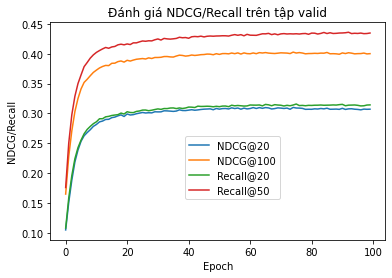

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(100)
plt.plot(epochs, trainer.n20_epochs[:-1], label='NDCG@20')
plt.plot(epochs, trainer.n100_epochs[:-1], label='NDCG@100')
plt.plot(epochs, trainer.r20_epochs[:-1], label='Recall@20')
plt.plot(epochs, trainer.r50_epochs[:-1], label='Recall@50')
plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Đánh giá NDCG/Recall trên tập valid')
plt.xlabel('Epoch')
plt.ylabel('NDCG/Recall')

In [ ]:
test_new_user = []
with open('data/train%s.txt'%path, 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = 1.0
                arr = csr_matrix(arr)
                test_new_user.append(arr)

num_test = len(test_new_user)

In [ ]:

torch.manual_seed(0)
# model_im = MultiVAE(num_songs=num_songs, name='VAE_100_300_implicit').to(device)
# model_im.load_state_dict(torch.load('/content/drive/MyDrive/RS20201/%s.pt'%model_im.name))
model_ex = MultiVAE(num_songs=num_songs, name='VAE_100_300_explicit').to(device)
model_ex.load_state_dict(torch.load('/content/drive/MyDrive/RS20201/%s.pt'%model_ex.name))

model_ex.eval()
n20, n100, r20, r50 = [], [], [], []
for i in range(num_test//500+1):
    top = (i+1)*500
    if top > num_test:
        top = num_test
    batch = np.array([arr.toarray()[0] for arr in test_new_user[i*500:top]])
    with torch.no_grad():
        inp = torch.zeros((batch.shape[0], batch.shape[1])).float().to(device)
        # print(inp.shape)
        logit, *_ = model_ex(inp)
    n100.append(NDCG_binary_at_k_batch(logit.detach().cpu().numpy(), batch, k=100))
    n20.append(NDCG_binary_at_k_batch(logit.detach().cpu().numpy(), batch, k=20))
    r20.append(Recall_at_k_batch(logit.detach().cpu().numpy(), batch, k=20))
    r50.append(Recall_at_k_batch(logit.detach().cpu().numpy(), batch, k=50))

print(bn.nanmean(np.concatenate(n20, axis=0)))
print(bn.nanmean(np.concatenate(n100, axis=0)))
print(bn.nanmean(np.concatenate(r20, axis=0)))
print(bn.nanmean(np.concatenate(r50, axis=0)))

0.08997956170894515
0.08269197215138138
0.07888148374683226
0.07136366014142653


In [ ]:
torch.manual_seed(0)

model = MultiVAE(num_songs=num_songs, name='VAE_100_300_explicit_normal')
trainer = Trainer(model, data=data, anneal_cap=0.2)
trainer.train()
trainer.validate(cmd='test')

Train:   0%|                                            | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
Train:   1%|▎                                   | 1/100 [00:03<05:40,  3.44s/it]


valid, epoch 0, step 50, best beta 0.01, max NDCG@20 0.08103, max NDCG@100 0.13497, max Recall@20 0.08694, max Recall@50 0.14687,NDCG@20 0.08103,NDCG@100 0.13497,Recall@20 0.08694,Recall@50 0.14687


Train:   2%|▋                                   | 2/100 [00:06<05:35,  3.42s/it]


valid, epoch 1, step 100, best beta 0.02, max NDCG@20 0.12741, max NDCG@100 0.19756, max Recall@20 0.13368, max Recall@50 0.21756,NDCG@20 0.12741,NDCG@100 0.19756,Recall@20 0.13368,Recall@50 0.21756


Train:   3%|█                                   | 3/100 [00:10<05:31,  3.42s/it]


valid, epoch 2, step 150, best beta 0.03, max NDCG@20 0.15719, max NDCG@100 0.23405, max Recall@20 0.16703, max Recall@50 0.25930,NDCG@20 0.15719,NDCG@100 0.23405,Recall@20 0.16703,Recall@50 0.25930


Train:   4%|█▍                                  | 4/100 [00:13<05:26,  3.41s/it]


valid, epoch 3, step 200, best beta 0.04, max NDCG@20 0.18114, max NDCG@100 0.26207, max Recall@20 0.18880, max Recall@50 0.28842,NDCG@20 0.18114,NDCG@100 0.26207,Recall@20 0.18880,Recall@50 0.28842


Train:   5%|█▊                                  | 5/100 [00:16<05:22,  3.40s/it]


valid, epoch 4, step 250, best beta 0.05, max NDCG@20 0.20492, max NDCG@100 0.28810, max Recall@20 0.20936, max Recall@50 0.31214,NDCG@20 0.20492,NDCG@100 0.28810,Recall@20 0.20936,Recall@50 0.31214


Train:   6%|██▏                                 | 6/100 [00:20<05:18,  3.38s/it]


valid, epoch 5, step 300, best beta 0.06, max NDCG@20 0.21948, max NDCG@100 0.30414, max Recall@20 0.22661, max Recall@50 0.33222,NDCG@20 0.21948,NDCG@100 0.30414,Recall@20 0.22661,Recall@50 0.33222


Train:   7%|██▌                                 | 7/100 [00:23<05:14,  3.38s/it]


valid, epoch 6, step 350, best beta 0.07, max NDCG@20 0.22925, max NDCG@100 0.31534, max Recall@20 0.23768, max Recall@50 0.34432,NDCG@20 0.22925,NDCG@100 0.31534,Recall@20 0.23768,Recall@50 0.34432


Train:   8%|██▉                                 | 8/100 [00:27<05:11,  3.39s/it]


valid, epoch 7, step 400, best beta 0.08, max NDCG@20 0.23554, max NDCG@100 0.32301, max Recall@20 0.24444, max Recall@50 0.35277,NDCG@20 0.23554,NDCG@100 0.32301,Recall@20 0.24444,Recall@50 0.35277


Train:   9%|███▏                                | 9/100 [00:30<05:06,  3.37s/it]


valid, epoch 8, step 450, best beta 0.09, max NDCG@20 0.24280, max NDCG@100 0.33107, max Recall@20 0.24943, max Recall@50 0.36178,NDCG@20 0.24280,NDCG@100 0.33107,Recall@20 0.24943,Recall@50 0.36178


Train:  10%|███▌                               | 10/100 [00:33<05:01,  3.35s/it]


valid, epoch 9, step 500, best beta 0.1, max NDCG@20 0.24729, max NDCG@100 0.33545, max Recall@20 0.25347, max Recall@50 0.36417,NDCG@20 0.24729,NDCG@100 0.33545,Recall@20 0.25347,Recall@50 0.36417


Train:  11%|███▊                               | 11/100 [00:37<04:57,  3.35s/it]


valid, epoch 10, step 550, best beta 0.11, max NDCG@20 0.25179, max NDCG@100 0.34060, max Recall@20 0.25827, max Recall@50 0.36987,NDCG@20 0.25179,NDCG@100 0.34060,Recall@20 0.25827,Recall@50 0.36987


Train:  12%|████▏                              | 12/100 [00:40<04:54,  3.35s/it]


valid, epoch 11, step 600, best beta 0.12, max NDCG@20 0.25405, max NDCG@100 0.34228, max Recall@20 0.26130, max Recall@50 0.37271,NDCG@20 0.25405,NDCG@100 0.34228,Recall@20 0.26130,Recall@50 0.37271


Train:  13%|████▌                              | 13/100 [00:43<04:50,  3.33s/it]


valid, epoch 12, step 650, best beta 0.12, max NDCG@20 0.25405, max NDCG@100 0.34228, max Recall@20 0.26249, max Recall@50 0.37330,NDCG@20 0.25334,NDCG@100 0.34165,Recall@20 0.26249,Recall@50 0.37330


Train:  14%|████▉                              | 14/100 [00:47<04:45,  3.32s/it]


valid, epoch 13, step 700, best beta 0.14, max NDCG@20 0.25860, max NDCG@100 0.34709, max Recall@20 0.26658, max Recall@50 0.37818,NDCG@20 0.25860,NDCG@100 0.34709,Recall@20 0.26658,Recall@50 0.37818


Train:  15%|█████▎                             | 15/100 [00:50<04:41,  3.31s/it]


valid, epoch 14, step 750, best beta 0.14, max NDCG@20 0.25860, max NDCG@100 0.34709, max Recall@20 0.26658, max Recall@50 0.37961,NDCG@20 0.25770,NDCG@100 0.34687,Recall@20 0.26627,Recall@50 0.37961


Train:  16%|█████▌                             | 16/100 [00:53<04:37,  3.31s/it]


valid, epoch 15, step 800, best beta 0.16, max NDCG@20 0.25925, max NDCG@100 0.34783, max Recall@20 0.26698, max Recall@50 0.37990,NDCG@20 0.25925,NDCG@100 0.34783,Recall@20 0.26698,Recall@50 0.37990


Train:  17%|█████▉                             | 17/100 [00:56<04:36,  3.33s/it]


valid, epoch 16, step 850, best beta 0.17, max NDCG@20 0.26024, max NDCG@100 0.34899, max Recall@20 0.26901, max Recall@50 0.38282,NDCG@20 0.26024,NDCG@100 0.34899,Recall@20 0.26901,Recall@50 0.38282


Train:  18%|██████▎                            | 18/100 [01:00<04:32,  3.32s/it]


valid, epoch 17, step 900, best beta 0.18, max NDCG@20 0.26568, max NDCG@100 0.35466, max Recall@20 0.27207, max Recall@50 0.38619,NDCG@20 0.26568,NDCG@100 0.35466,Recall@20 0.27207,Recall@50 0.38619


Train:  19%|██████▋                            | 19/100 [01:03<04:28,  3.32s/it]


valid, epoch 18, step 950, best beta 0.19, max NDCG@20 0.26577, max NDCG@100 0.35470, max Recall@20 0.27223, max Recall@50 0.38619,NDCG@20 0.26577,NDCG@100 0.35470,Recall@20 0.27223,Recall@50 0.38585


Train:  20%|███████                            | 20/100 [01:06<04:24,  3.30s/it]


valid, epoch 19, step 1000, best beta 0.19, max NDCG@20 0.26577, max NDCG@100 0.35470, max Recall@20 0.27223, max Recall@50 0.38619,NDCG@20 0.26244,NDCG@100 0.35223,Recall@20 0.26997,Recall@50 0.38464


Train:  21%|███████▎                           | 21/100 [01:10<04:23,  3.34s/it]


valid, epoch 20, step 1050, best beta 0.19, max NDCG@20 0.26577, max NDCG@100 0.35470, max Recall@20 0.27487, max Recall@50 0.38717,NDCG@20 0.26476,NDCG@100 0.35378,Recall@20 0.27487,Recall@50 0.38717


Train:  22%|███████▋                           | 22/100 [01:13<04:18,  3.31s/it]


valid, epoch 21, step 1100, best beta 0.19, max NDCG@20 0.26577, max NDCG@100 0.35470, max Recall@20 0.27487, max Recall@50 0.38717,NDCG@20 0.26528,NDCG@100 0.35449,Recall@20 0.27397,Recall@50 0.38690


Train:  23%|████████                           | 23/100 [01:16<04:17,  3.34s/it]


valid, epoch 22, step 1150, best beta 0.23, max NDCG@20 0.26664, max NDCG@100 0.35665, max Recall@20 0.27487, max Recall@50 0.38961,NDCG@20 0.26664,NDCG@100 0.35665,Recall@20 0.27443,Recall@50 0.38961


Train:  24%|████████▍                          | 24/100 [01:20<04:14,  3.35s/it]


valid, epoch 23, step 1200, best beta 0.24, max NDCG@20 0.27085, max NDCG@100 0.35873, max Recall@20 0.27859, max Recall@50 0.39044,NDCG@20 0.27085,NDCG@100 0.35873,Recall@20 0.27859,Recall@50 0.39044


Train:  25%|████████▊                          | 25/100 [01:23<04:08,  3.32s/it]


valid, epoch 24, step 1250, best beta 0.24, max NDCG@20 0.27085, max NDCG@100 0.35873, max Recall@20 0.27859, max Recall@50 0.39044,NDCG@20 0.26983,NDCG@100 0.35811,Recall@20 0.27833,Recall@50 0.38901


Train:  26%|█████████                          | 26/100 [01:26<04:05,  3.32s/it]


valid, epoch 25, step 1300, best beta 0.26, max NDCG@20 0.27085, max NDCG@100 0.35937, max Recall@20 0.27859, max Recall@50 0.39180,NDCG@20 0.26920,NDCG@100 0.35937,Recall@20 0.27715,Recall@50 0.39180


Train:  27%|█████████▍                         | 27/100 [01:30<04:02,  3.32s/it]


valid, epoch 26, step 1350, best beta 0.27, max NDCG@20 0.27113, max NDCG@100 0.36006, max Recall@20 0.27942, max Recall@50 0.39350,NDCG@20 0.27113,NDCG@100 0.36006,Recall@20 0.27942,Recall@50 0.39350


Train:  28%|█████████▊                         | 28/100 [01:33<03:58,  3.32s/it]


valid, epoch 27, step 1400, best beta 0.28, max NDCG@20 0.27125, max NDCG@100 0.36027, max Recall@20 0.28002, max Recall@50 0.39375,NDCG@20 0.27125,NDCG@100 0.36027,Recall@20 0.28002,Recall@50 0.39375


Train:  29%|██████████▏                        | 29/100 [01:36<03:55,  3.32s/it]


valid, epoch 28, step 1450, best beta 0.29, max NDCG@20 0.27138, max NDCG@100 0.36092, max Recall@20 0.28002, max Recall@50 0.39428,NDCG@20 0.27138,NDCG@100 0.36092,Recall@20 0.27846,Recall@50 0.39428


Train:  30%|██████████▌                        | 30/100 [01:40<03:51,  3.30s/it]


valid, epoch 29, step 1500, best beta 0.29, max NDCG@20 0.27138, max NDCG@100 0.36092, max Recall@20 0.28002, max Recall@50 0.39572,NDCG@20 0.27088,NDCG@100 0.36039,Recall@20 0.27919,Recall@50 0.39572


Train:  31%|██████████▊                        | 31/100 [01:43<03:48,  3.32s/it]


valid, epoch 30, step 1550, best beta 0.31, max NDCG@20 0.27325, max NDCG@100 0.36223, max Recall@20 0.28057, max Recall@50 0.39572,NDCG@20 0.27325,NDCG@100 0.36223,Recall@20 0.28057,Recall@50 0.39521


Train:  32%|███████████▏                       | 32/100 [01:46<03:44,  3.31s/it]


valid, epoch 31, step 1600, best beta 0.31, max NDCG@20 0.27325, max NDCG@100 0.36223, max Recall@20 0.28057, max Recall@50 0.39572,NDCG@20 0.27174,NDCG@100 0.36149,Recall@20 0.28021,Recall@50 0.39566


Train:  33%|███████████▌                       | 33/100 [01:50<03:42,  3.32s/it]


valid, epoch 32, step 1650, best beta 0.33, max NDCG@20 0.27455, max NDCG@100 0.36373, max Recall@20 0.28206, max Recall@50 0.39572,NDCG@20 0.27455,NDCG@100 0.36373,Recall@20 0.28206,Recall@50 0.39476


Train:  34%|███████████▉                       | 34/100 [01:53<03:39,  3.32s/it]


valid, epoch 33, step 1700, best beta 0.34, max NDCG@20 0.27465, max NDCG@100 0.36401, max Recall@20 0.28206, max Recall@50 0.39572,NDCG@20 0.27465,NDCG@100 0.36401,Recall@20 0.28088,Recall@50 0.39562


Train:  35%|████████████▎                      | 35/100 [01:56<03:35,  3.32s/it]


valid, epoch 34, step 1750, best beta 0.35, max NDCG@20 0.27593, max NDCG@100 0.36512, max Recall@20 0.28238, max Recall@50 0.39572,NDCG@20 0.27593,NDCG@100 0.36512,Recall@20 0.28238,Recall@50 0.39494


Train:  36%|████████████▌                      | 36/100 [02:00<03:33,  3.33s/it]


valid, epoch 35, step 1800, best beta 0.36, max NDCG@20 0.27762, max NDCG@100 0.36580, max Recall@20 0.28441, max Recall@50 0.39572,NDCG@20 0.27762,NDCG@100 0.36580,Recall@20 0.28441,Recall@50 0.39493


Train:  37%|████████████▉                      | 37/100 [02:03<03:28,  3.30s/it]


valid, epoch 36, step 1850, best beta 0.36, max NDCG@20 0.27762, max NDCG@100 0.36580, max Recall@20 0.28441, max Recall@50 0.39572,NDCG@20 0.27493,NDCG@100 0.36476,Recall@20 0.28135,Recall@50 0.39498


Train:  38%|█████████████▎                     | 38/100 [02:06<03:25,  3.31s/it]


valid, epoch 37, step 1900, best beta 0.38, max NDCG@20 0.27762, max NDCG@100 0.36586, max Recall@20 0.28441, max Recall@50 0.39703,NDCG@20 0.27683,NDCG@100 0.36586,Recall@20 0.28311,Recall@50 0.39703


Train:  39%|█████████████▋                     | 39/100 [02:09<03:20,  3.29s/it]


valid, epoch 38, step 1950, best beta 0.38, max NDCG@20 0.27762, max NDCG@100 0.36586, max Recall@20 0.28441, max Recall@50 0.39703,NDCG@20 0.27586,NDCG@100 0.36560,Recall@20 0.28319,Recall@50 0.39649


Train:  40%|██████████████                     | 40/100 [02:13<03:16,  3.28s/it]


valid, epoch 39, step 2000, best beta 0.38, max NDCG@20 0.27762, max NDCG@100 0.36586, max Recall@20 0.28441, max Recall@50 0.39703,NDCG@20 0.27623,NDCG@100 0.36560,Recall@20 0.28272,Recall@50 0.39604


Train:  41%|██████████████▎                    | 41/100 [02:16<03:11,  3.25s/it]


valid, epoch 40, step 2050, best beta 0.38, max NDCG@20 0.27762, max NDCG@100 0.36586, max Recall@20 0.28441, max Recall@50 0.39703,NDCG@20 0.27376,NDCG@100 0.36400,Recall@20 0.28206,Recall@50 0.39702


Train:  42%|██████████████▋                    | 42/100 [02:19<03:08,  3.26s/it]


valid, epoch 41, step 2100, best beta 0.42, max NDCG@20 0.27762, max NDCG@100 0.36664, max Recall@20 0.28441, max Recall@50 0.39794,NDCG@20 0.27652,NDCG@100 0.36664,Recall@20 0.28361,Recall@50 0.39794


Train:  43%|███████████████                    | 43/100 [02:22<03:04,  3.24s/it]


valid, epoch 42, step 2150, best beta 0.42, max NDCG@20 0.27762, max NDCG@100 0.36664, max Recall@20 0.28441, max Recall@50 0.39794,NDCG@20 0.27474,NDCG@100 0.36531,Recall@20 0.28258,Recall@50 0.39710


Train:  44%|███████████████▍                   | 44/100 [02:26<03:01,  3.24s/it]


valid, epoch 43, step 2200, best beta 0.42, max NDCG@20 0.27762, max NDCG@100 0.36664, max Recall@20 0.28441, max Recall@50 0.39794,NDCG@20 0.27669,NDCG@100 0.36647,Recall@20 0.28421,Recall@50 0.39764


Train:  45%|███████████████▊                   | 45/100 [02:29<02:57,  3.22s/it]


valid, epoch 44, step 2250, best beta 0.42, max NDCG@20 0.27762, max NDCG@100 0.36664, max Recall@20 0.28481, max Recall@50 0.39866,NDCG@20 0.27579,NDCG@100 0.36607,Recall@20 0.28481,Recall@50 0.39866


Train:  46%|████████████████                   | 46/100 [02:32<02:53,  3.21s/it]


valid, epoch 45, step 2300, best beta 0.42, max NDCG@20 0.27762, max NDCG@100 0.36664, max Recall@20 0.28494, max Recall@50 0.39973,NDCG@20 0.27539,NDCG@100 0.36572,Recall@20 0.28494,Recall@50 0.39973


Train:  47%|████████████████▍                  | 47/100 [02:35<02:49,  3.20s/it]


valid, epoch 46, step 2350, best beta 0.42, max NDCG@20 0.27762, max NDCG@100 0.36664, max Recall@20 0.28516, max Recall@50 0.39973,NDCG@20 0.27653,NDCG@100 0.36660,Recall@20 0.28516,Recall@50 0.39864


Train:  48%|████████████████▊                  | 48/100 [02:38<02:47,  3.22s/it]


valid, epoch 47, step 2400, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28534, max Recall@50 0.39973,NDCG@20 0.27784,NDCG@100 0.36764,Recall@20 0.28534,Recall@50 0.39969


Train:  49%|█████████████████▏                 | 49/100 [02:42<02:44,  3.22s/it]


valid, epoch 48, step 2450, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28534, max Recall@50 0.39973,NDCG@20 0.27712,NDCG@100 0.36723,Recall@20 0.28432,Recall@50 0.39896


Train:  50%|█████████████████▌                 | 50/100 [02:45<02:40,  3.22s/it]


valid, epoch 49, step 2500, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.39982,NDCG@20 0.27764,NDCG@100 0.36711,Recall@20 0.28569,Recall@50 0.39982


Train:  51%|█████████████████▊                 | 51/100 [02:48<02:37,  3.21s/it]


valid, epoch 50, step 2550, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.39982,NDCG@20 0.27569,NDCG@100 0.36649,Recall@20 0.28367,Recall@50 0.39939


Train:  52%|██████████████████▏                | 52/100 [02:51<02:33,  3.21s/it]


valid, epoch 51, step 2600, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.40164,NDCG@20 0.27575,NDCG@100 0.36694,Recall@20 0.28370,Recall@50 0.40164


Train:  53%|██████████████████▌                | 53/100 [02:54<02:29,  3.19s/it]


valid, epoch 52, step 2650, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.40164,NDCG@20 0.27659,NDCG@100 0.36749,Recall@20 0.28437,Recall@50 0.40017


Train:  54%|██████████████████▉                | 54/100 [02:57<02:26,  3.18s/it]


valid, epoch 53, step 2700, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.40164,NDCG@20 0.27419,NDCG@100 0.36566,Recall@20 0.28349,Recall@50 0.40080


Train:  55%|███████████████████▎               | 55/100 [03:01<02:23,  3.18s/it]


valid, epoch 54, step 2750, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.40164,NDCG@20 0.27494,NDCG@100 0.36619,Recall@20 0.28438,Recall@50 0.40127


Train:  56%|███████████████████▌               | 56/100 [03:04<02:20,  3.19s/it]


valid, epoch 55, step 2800, best beta 0.48, max NDCG@20 0.27784, max NDCG@100 0.36764, max Recall@20 0.28569, max Recall@50 0.40164,NDCG@20 0.27655,NDCG@100 0.36702,Recall@20 0.28459,Recall@50 0.40071


Train:  57%|███████████████████▉               | 57/100 [03:07<02:18,  3.22s/it]


valid, epoch 56, step 2850, best beta 0.57, max NDCG@20 0.27784, max NDCG@100 0.36820, max Recall@20 0.28619, max Recall@50 0.40208,NDCG@20 0.27735,NDCG@100 0.36820,Recall@20 0.28619,Recall@50 0.40208


Train:  58%|████████████████████▎              | 58/100 [03:11<02:16,  3.25s/it]


valid, epoch 57, step 2900, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40212,NDCG@20 0.27943,NDCG@100 0.36995,Recall@20 0.28736,Recall@50 0.40212


Train:  59%|████████████████████▋              | 59/100 [03:14<02:13,  3.25s/it]


valid, epoch 58, step 2950, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40212,NDCG@20 0.27604,NDCG@100 0.36775,Recall@20 0.28448,Recall@50 0.40174


Train:  60%|█████████████████████              | 60/100 [03:17<02:09,  3.24s/it]


valid, epoch 59, step 3000, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40212,NDCG@20 0.27774,NDCG@100 0.36819,Recall@20 0.28700,Recall@50 0.40096


Train:  61%|█████████████████████▎             | 61/100 [03:20<02:06,  3.25s/it]


valid, epoch 60, step 3050, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27751,NDCG@100 0.36823,Recall@20 0.28649,Recall@50 0.40391


Train:  62%|█████████████████████▋             | 62/100 [03:23<02:03,  3.24s/it]


valid, epoch 61, step 3100, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27793,NDCG@100 0.36858,Recall@20 0.28612,Recall@50 0.40114


Train:  63%|██████████████████████             | 63/100 [03:27<02:00,  3.25s/it]


valid, epoch 62, step 3150, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27911,NDCG@100 0.36972,Recall@20 0.28714,Recall@50 0.40335


Train:  64%|██████████████████████▍            | 64/100 [03:30<01:56,  3.24s/it]


valid, epoch 63, step 3200, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27522,NDCG@100 0.36644,Recall@20 0.28512,Recall@50 0.40185


Train:  65%|██████████████████████▊            | 65/100 [03:33<01:53,  3.24s/it]


valid, epoch 64, step 3250, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27667,NDCG@100 0.36759,Recall@20 0.28486,Recall@50 0.40137


Train:  66%|███████████████████████            | 66/100 [03:36<01:50,  3.24s/it]


valid, epoch 65, step 3300, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27752,NDCG@100 0.36839,Recall@20 0.28562,Recall@50 0.40209


Train:  67%|███████████████████████▍           | 67/100 [03:40<01:46,  3.23s/it]


valid, epoch 66, step 3350, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27581,NDCG@100 0.36730,Recall@20 0.28496,Recall@50 0.40135


Train:  68%|███████████████████████▊           | 68/100 [03:43<01:43,  3.23s/it]


valid, epoch 67, step 3400, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28736, max Recall@50 0.40391,NDCG@20 0.27698,NDCG@100 0.36723,Recall@20 0.28662,Recall@50 0.40058


Train:  69%|████████████████████████▏          | 69/100 [03:46<01:40,  3.23s/it]


valid, epoch 68, step 3450, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27824,NDCG@100 0.36877,Recall@20 0.28793,Recall@50 0.40324


Train:  70%|████████████████████████▌          | 70/100 [03:49<01:37,  3.23s/it]


valid, epoch 69, step 3500, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27596,NDCG@100 0.36757,Recall@20 0.28540,Recall@50 0.40085


Train:  71%|████████████████████████▊          | 71/100 [03:53<01:33,  3.23s/it]


valid, epoch 70, step 3550, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27663,NDCG@100 0.36791,Recall@20 0.28670,Recall@50 0.40226


Train:  72%|█████████████████████████▏         | 72/100 [03:56<01:29,  3.21s/it]


valid, epoch 71, step 3600, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27697,NDCG@100 0.36794,Recall@20 0.28624,Recall@50 0.40098


Train:  73%|█████████████████████████▌         | 73/100 [03:59<01:26,  3.21s/it]


valid, epoch 72, step 3650, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27600,NDCG@100 0.36777,Recall@20 0.28464,Recall@50 0.40147


Train:  74%|█████████████████████████▉         | 74/100 [04:02<01:23,  3.20s/it]


valid, epoch 73, step 3700, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27678,NDCG@100 0.36842,Recall@20 0.28667,Recall@50 0.40344


Train:  75%|██████████████████████████▎        | 75/100 [04:05<01:19,  3.19s/it]


valid, epoch 74, step 3750, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27794,NDCG@100 0.36879,Recall@20 0.28630,Recall@50 0.40227


Train:  76%|██████████████████████████▌        | 76/100 [04:08<01:16,  3.20s/it]


valid, epoch 75, step 3800, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27626,NDCG@100 0.36760,Recall@20 0.28566,Recall@50 0.40087


Train:  77%|██████████████████████████▉        | 77/100 [04:12<01:13,  3.21s/it]


valid, epoch 76, step 3850, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27612,NDCG@100 0.36764,Recall@20 0.28492,Recall@50 0.40195


Train:  78%|███████████████████████████▎       | 78/100 [04:15<01:10,  3.23s/it]


valid, epoch 77, step 3900, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27610,NDCG@100 0.36832,Recall@20 0.28511,Recall@50 0.40190


Train:  79%|███████████████████████████▋       | 79/100 [04:18<01:07,  3.22s/it]


valid, epoch 78, step 3950, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27822,NDCG@100 0.36937,Recall@20 0.28593,Recall@50 0.40174


Train:  80%|████████████████████████████       | 80/100 [04:21<01:04,  3.21s/it]


valid, epoch 79, step 4000, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27759,NDCG@100 0.36906,Recall@20 0.28671,Recall@50 0.40320


Train:  81%|████████████████████████████▎      | 81/100 [04:25<01:00,  3.19s/it]


valid, epoch 80, step 4050, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27728,NDCG@100 0.36876,Recall@20 0.28712,Recall@50 0.40305


Train:  82%|████████████████████████████▋      | 82/100 [04:28<00:57,  3.17s/it]


valid, epoch 81, step 4100, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40391,NDCG@20 0.27776,NDCG@100 0.36896,Recall@20 0.28753,Recall@50 0.40189


Train:  83%|█████████████████████████████      | 83/100 [04:31<00:53,  3.17s/it]


valid, epoch 82, step 4150, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28793, max Recall@50 0.40642,NDCG@20 0.27693,NDCG@100 0.36912,Recall@20 0.28584,Recall@50 0.40642


Train:  84%|█████████████████████████████▍     | 84/100 [04:34<00:50,  3.16s/it]


valid, epoch 83, step 4200, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27772,NDCG@100 0.36921,Recall@20 0.28824,Recall@50 0.40488


Train:  85%|█████████████████████████████▊     | 85/100 [04:37<00:47,  3.17s/it]


valid, epoch 84, step 4250, best beta 0.58, max NDCG@20 0.27943, max NDCG@100 0.36995, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27718,NDCG@100 0.36876,Recall@20 0.28618,Recall@50 0.40266


Train:  86%|██████████████████████████████     | 86/100 [04:40<00:44,  3.21s/it]


valid, epoch 85, step 4300, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27812,NDCG@100 0.37052,Recall@20 0.28656,Recall@50 0.40425


Train:  87%|██████████████████████████████▍    | 87/100 [04:44<00:41,  3.21s/it]


valid, epoch 86, step 4350, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27708,NDCG@100 0.36900,Recall@20 0.28726,Recall@50 0.40406


Train:  88%|██████████████████████████████▊    | 88/100 [04:47<00:38,  3.23s/it]


valid, epoch 87, step 4400, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27563,NDCG@100 0.36776,Recall@20 0.28624,Recall@50 0.40423


Train:  89%|███████████████████████████████▏   | 89/100 [04:50<00:35,  3.21s/it]


valid, epoch 88, step 4450, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27386,NDCG@100 0.36693,Recall@20 0.28362,Recall@50 0.40228


Train:  90%|███████████████████████████████▌   | 90/100 [04:53<00:32,  3.20s/it]


valid, epoch 89, step 4500, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27545,NDCG@100 0.36871,Recall@20 0.28569,Recall@50 0.40499


Train:  91%|███████████████████████████████▊   | 91/100 [04:57<00:28,  3.21s/it]


valid, epoch 90, step 4550, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27563,NDCG@100 0.36823,Recall@20 0.28647,Recall@50 0.40389


Train:  92%|████████████████████████████████▏  | 92/100 [05:00<00:25,  3.21s/it]


valid, epoch 91, step 4600, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27697,NDCG@100 0.36885,Recall@20 0.28739,Recall@50 0.40428


Train:  93%|████████████████████████████████▌  | 93/100 [05:03<00:22,  3.18s/it]


valid, epoch 92, step 4650, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28824, max Recall@50 0.40642,NDCG@20 0.27577,NDCG@100 0.36843,Recall@20 0.28620,Recall@50 0.40580


Train:  94%|████████████████████████████████▉  | 94/100 [05:06<00:19,  3.19s/it]


valid, epoch 93, step 4700, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27795,NDCG@100 0.36965,Recall@20 0.28912,Recall@50 0.40764


Train:  95%|█████████████████████████████████▎ | 95/100 [05:09<00:15,  3.20s/it]


valid, epoch 94, step 4750, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27607,NDCG@100 0.36828,Recall@20 0.28607,Recall@50 0.40420


Train:  96%|█████████████████████████████████▌ | 96/100 [05:13<00:12,  3.22s/it]


valid, epoch 95, step 4800, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27610,NDCG@100 0.36867,Recall@20 0.28593,Recall@50 0.40445


Train:  97%|█████████████████████████████████▉ | 97/100 [05:16<00:09,  3.24s/it]


valid, epoch 96, step 4850, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27701,NDCG@100 0.36903,Recall@20 0.28682,Recall@50 0.40589


Train:  98%|██████████████████████████████████▎| 98/100 [05:19<00:06,  3.24s/it]


valid, epoch 97, step 4900, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27767,NDCG@100 0.37013,Recall@20 0.28664,Recall@50 0.40445


Train:  99%|██████████████████████████████████▋| 99/100 [05:22<00:03,  3.26s/it]


valid, epoch 98, step 4950, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27606,NDCG@100 0.36865,Recall@20 0.28600,Recall@50 0.40546


Train: 100%|██████████████████████████████████| 100/100 [05:26<00:00,  3.26s/it]


valid, epoch 99, step 5000, best beta 0.86, max NDCG@20 0.27943, max NDCG@100 0.37052, max Recall@20 0.28912, max Recall@50 0.40764,NDCG@20 0.27657,NDCG@100 0.36897,Recall@20 0.28668,Recall@50 0.40475



test, epoch 99, step 5000, best beta 0.86, max NDCG@20 0.28165, max NDCG@100 0.37198, max Recall@20 0.29380, max Recall@50 0.40815,NDCG@20 0.28165,NDCG@100 0.37198,Recall@20 0.29380,Recall@50 0.40815


In [ ]:
num_songs = 19661
path = '_100_300'

with open('data/unique_song%s.txt'%path, 'r') as f:
    stoi = dict([(line.split(':')[0], int(line.split(':')[1])) for line in f.read().splitlines()])
num_songs = len(stoi.keys())
print(num_songs)

def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

class MSD(Dataset):

    def __init__(self, split='train', conditioned_on=None, upper=-1):

        super(MSD, self).__init__()
        self.split = split
        self.data_tr, self.data_te, self.data_va = [], [], []
        with open('data/train (1).txt', 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = 1.0
                arr = csr_matrix(arr)
                self.data_tr.append(arr)

        with open('data/test (1).txt', 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = 1.0
                arr = csr_matrix(arr)
                self.data_te.append(arr)
              
        with open('data/valid (1).txt', 'r') as f:
            for line in f.read().splitlines():
                mem = line.split(' ')
                if len(mem) == 0:
                    continue
                arr = np.zeros(num_songs)
                for inst in mem:
                    if '<fff>' not in inst:
                        continue
                    u, s, r = inst.split('<fff>')
                    arr[stoi[s]] = 1.0
                arr = csr_matrix(arr)
                self.data_va.append(arr)

        self.n_tr = len(self.data_tr)
        

    def __len__(self):
        return self.n_tr

    def __getitem__(self, index):
        if self.split == 'train':
            tr= self.data_tr[index].toarray()[0]
            return tr
        elif self.split == 'test':
            tr= self.data_tr[index].toarray()[0]
            te = self.data_te[index].toarray()[0]
            return tr, te
        else:
            tr= self.data_tr[index].toarray()[0]
            va = self.data_va[index].toarray()[0]
            return tr, va

data = MSD()

3231


In [ ]:
with open('/content/drive/MyDrive/RS20201/data/train.txt', 'r') as f:
  train_data = [line.split('<fff>') for line in f.read().splitlines()]

with open('/content/drive/MyDrive/RS20201/data/test.txt', 'r') as f:
  test_data = [line.split('<fff>') for line in f.read().splitlines()]


user_ids = list(set([line[0] for line in train_data]))
song_ids = list(set([line[1] for line in train_data]))

num_users = len(user_ids)
num_songs = len(song_ids)
print('num users:', num_users)
print('num songs:', num_songs)
user_ids_to_idx = dict(zip(user_ids, range(num_users)))
song_ids_to_idx = dict(zip(song_ids, range(num_songs)))

Y = np.zeros((num_users, num_songs))
max_rate = 0
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

for i in range(len(train_data)):
    u = user_ids_to_idx[train_data[i][0]]
    s = song_ids_to_idx[train_data[i][1]]
    r = int(train_data[i][2])
    if r > max_rate:
        max_rate = r
    Y[u][s] = r
    
Y = csr_matrix(Y)
print('max rate:',max_rate)
print('num rating:',len(train_data))
print('density:', len(train_data)/(num_users*num_songs))

# train_data = dict([((line[0], line[1]), int(line[2])) for line in train_data])
# test_data = dict([((line[0], line[1]), int(line[2])) for line in test_data])


num users: 33963
num songs: 5527
max rate: 2213
num rating: 845387
density: 0.004503602540554609


In [ ]:
min_user_react = 10
min_song_react = 10

def get_train_test():
    print('splitting train and test data...')
    with open('/content/drive/MyDrive/RS20201/data/user_song_data_wc.txt', 'r') as f:
        data = [line.split('<fff>') for line in f.read().splitlines()]
    train = []
    test = []
    mem = []
    # user
    data = sorted(data, key=lambda x: x[0])
    for i in range(len(data) - 1):
        user, item, rating = data[i][0], data[i][1], data[i][2]
        mem.append([user, item, rating])
        if data[i][0] != data[i + 1][0]:
            if len(mem) >= min_user_react:
                test.append(mem[-1])
                train += mem[:-1]
            else:
                test += mem
            
            mem = []
    test.append([data[-1][0], data[-1][1], data[-1][2]])

    # song
    data = sorted(train, key=lambda x: x[1])
    train = []
    mem = []
    for i in range(len(data) - 1):
        user, item, rating = data[i][0], data[i][1], data[i][2]
        mem.append([user, item, rating])
        if data[i][1] != data[i + 1][1]:
            if len(mem) >= min_song_react:
                train += mem
            else:
                test += mem
            
            mem = []
    test.append([data[-1][0], data[-1][1], data[-1][2]])

    train = ['<fff>'.join(line) for line in train]
    test = ['<fff>'.join(line) for line in test]
    print('train size:', len(train))
    print('test size:', len(test))

    with open('/content/drive/MyDrive/RS20201/data/train.txt', 'w') as f:
        f.write('\n'.join(train))
    with open('/content/drive/MyDrive/RS20201/data/test.txt', 'w') as f:
        f.write('\n'.join(test))
    return

get_train_test()


splitting train and test data...
train size: 845387
test size: 234335


In [ ]:
mask = (Y>0)*1.0
Y_copy = Y.copy()
mask_copy = mask.copy()
mu = Y.sum()/mask.sum()
print(mu)


0.821734201016593


In [ ]:
class WMF(nn.Module):
    def __init__(self, num_users, num_songs, latent_size):
        super().__init__()
        self.user_w = nn.Embedding(num_users, latent_size)
        self.song_w = nn.Embedding(num_songs, latent_size)

        self.user_b = nn.Embedding(num_users, 1)
        self.song_b = nn.Embedding(num_songs, 1)

    def forward(self, u, s):
        u = torch.tensor(u).to(device)
        s = torch.tensor(s).to(device)
        # out = torch.tensor([self.user_w(u[i]).dot(self.song_w(s[i])) for i in range(u.shape[0])])
        return self.user_w(u).dot(self.song_w(s)) + self.user_b(u) + self.song_b(s)

def train(model, num_epochs=100, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    ce = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for u_id, s_id, lc in train_data:
            u = user_ids_to_idx[u_id]
            s = song_ids_to_idx[s_id]
            c = sigmoid(int(lc))
            optimizer.zero_grad()
            out = model(u, s)
            # print(out)
            loss = c*ce(out, torch.ones(1).to(device))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        if epoch % 1 == 0:
            # mae = eval(model)
            # if best > mae:
            #     best = mae
            #     torch.save(model.state_dict(), '/content/drive/MyDrive/RS20201/model.pt')

            print(epoch, total_loss/len(train_data))


In [ ]:
wmf = WMF(num_users, num_songs, 128).to(device)

train(wmf)

In [ ]:
class AutoRec(nn.Module):
    def __init__(self, num_songs, embedding_size=256, n_hidden=128):
        super().__init__()
        self.num_songs = num_songs
        self.embedding_size = embedding_size
        self.n_hidden = n_hidden
        self.encoder = nn.Sequential(
            nn.Linear(num_songs, n_hidden),
            nn.SELU(),
            nn.Linear(n_hidden, embedding_size),
            nn.SELU(),
            nn.Dropout(0.8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, n_hidden),
            nn.SELU(),
            nn.Linear(n_hidden, num_songs),
            nn.SELU()
        )

    def forward(self, inp):
        latent = self.encoder(inp)
        out = self.decoder(latent)
        return out

In [ ]:
def criterion(r_pred, r_true):
    _mask = (r_true!=0)*1.0
    diff = r_pred - r_true
    loss = diff*diff*_mask
    # print(torch.sum(loss))
    # print(torch.sum(_mask))
    return torch.sum(loss)/torch.sum(_mask)

def MSEloss(inputs, targets):
  mask = targets != 0
  criterion = nn.MSELoss()
  return criterion(inputs * mask.float(), targets)

def train(model, Y, mask, num_epochs=100, batch_size=128, lr=0.001):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    num_batchs = num_users//batch_size + 1
    model.train()
    best = np.inf
    for epoch in range(num_epochs):
        total_loss = 0
        Y, mask = shuffle(Y, mask)
        for i in range(num_batchs):
            optimizer.zero_grad()
            top = (i+1)*batch_size if (i+1)*batch_size < num_users else num_users
            inp = Y[i*batch_size: top].toarray()
            # m = mask[i*batch_size: top].toarray()
            # inp = inp - mu*m
            inp = torch.tensor(inp).float().to(device)
            out = model(inp)
            loss = MSEloss(out, inp)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            # re-feeding
            optimizer.zero_grad()
            inp = out.detach()
            out = model(inp)
            loss = MSEloss(out, inp)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            mae = eval(model)
            if best > mae:
                best = mae
                torch.save(model.state_dict(), '/content/drive/MyDrive/RS20201/model.pt')

            print(epoch, total_loss/num_batchs, mae)

def eval(model):
    model.eval()
    mae = []
    ndcg = []
    for u_id, s_id in train_data:
        # if u_id not in user_ids_to_idx or s_id not in song_ids_to_idx:
        #     continue
        u = user_ids_to_idx[u_id]
        s = song_ids_to_idx[s_id]
        inp = Y_copy[u].toarray()[0]
        with torch.no_grad():
            pred = model(torch.tensor(inp).float().to(device)).cpu().numpy()
        for i, r in enumerate(pred):
            if s == i:
                # print(r, train_data[(u_id, s_id)])
                mae.append(np.abs(r-train_data[(u_id, s_id)]))
                break
        # pred_list = [ for i, r in enumerate(pred) if (u_id, song_ids[i]) not in train_data]

    return np.mean(mae) #np.mean(ndcg)



In [ ]:
model = AutoRec(num_songs).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/RS20201/model.pt'))

print(eval(model))

In [ ]:
model = AutoRec(num_songs).to(device)
train(model, Y, mask, num_epochs=500, batch_size=128, lr=0.001)

0 0.012246122663399498
10 0.005990718276488518
20 0.005179327318297797
30 0.004861931965154197
40 0.004652402053860233
50 0.004489694449339846
60 0.004353923997071509
70 0.0042368514065917835
80 0.004123278845826346
90 0.004034488878555988
100 0.003941465319305854
110 0.003870543347640117
120 0.003796393169471784
130 0.0037248845993807273
140 0.0036707000821807833
150 0.0036081079594069685
160 0.0035582825154612274
170 0.0035051849812507293
180 0.003457754194347846
190 0.0034103939914550715
200 0.003364471205741279
210 0.003327524957782764
220 0.003289479890110013
230 0.003249914282530238
240 0.003215034381150359
250 0.0031766407988279275
260 0.0031420235330399996
270 0.0031107153237580243
280 0.003079534496033662
290 0.003051189523666425
300 0.0030256220558833305
310 0.00299895486594843
320 0.0029719525189278997
330 0.0029463836038310107
340 0.002924937022678358
350 0.0029015119057988984
360 0.0028742255876716086
370 0.0028566682069646404
380 0.0028342032941632476
390 0.00281218726089

In [ ]:
def recommend(user):
    inp = Y[user].toarray() - mu*mask[user].toarray()
    inp = torch.tensor(inp).float().to(device)
    out = model(inp)
    return out[-1]

out = recommend(1)
out = out.cpu().detach().numpy()
out = out + mu
out = out*mask[1].toarray()
for i in zip(list(out), list(Y[1].toarray())):
    print(i)

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))


In [ ]:
class RecSys(nn.Module):
    def __init__(self, num_users, num_songs, embedding_size, n_hidden=256):
        super().__init__()
        self.num_users = num_users
        self.num_songs = num_songs
        self.embedding_size = embedding_size
        self.n_hidden = n_hidden
        self.user_encode = nn.Sequential(
            nn.Linear(num_songs, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, embedding_size)
        )
        self.song_encode = nn.Sequential(
            nn.Linear(num_users, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, embedding_size)
        )
        self.cosine = nn.CosineSimilarity()


    def forward(self, user, song):
        user = torch.tensor(user).cuda().float()
        song = torch.tensor(song).cuda().float()
        p = self.user_encode(user)
        q = self.song_encode(song)
        out = self.cosine(p, q)
        out = torch.max(out, torch.tensor(1e-9).cuda().float()).cuda().float()
        return p, q, out

In [ ]:
model = RecSys(num_users=num_users, num_songs=num_songs, embedding_size=64).cuda().float()
p, q, out = model(Y[:2],Y.T[:2])
print(p.shape,q.shape)
print(out)

torch.Size([2, 64]) torch.Size([2, 64])
tensor([0.1858, 0.1690], device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
print(model.state_dict())

In [ ]:
def get_train_instances(num_negatives):
    user_input = []
    item_input = []
    ratings = []
    for user_id, song_id, rating in train_data:
        user_input.append(user_id)
        item_input.append(song_id)
        ratings.append(rating)

        # negative samples
        item_list = []
        for t in range(num_negatives):
            j = np.random.randint(num_songs)
            if Y[user_id, j] == 0:
                user_input.append(user_id)
                item_input.append(j)
                ratings.append(0)
    return np.array(user_input), np.array(item_input), np.array(ratings)



def train(model, num_negatives=1, num_epochs=10, batch_size=10000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs+1):
        c1 = time.time()
        model.train()
        total_loss = 0
        user_input, song_input, ratings = get_train_instances(num_negatives)
        num_instance = len(ratings)
        num_batchs = num_instance // batch_size + 1
        indices = np.arange(num_instance)
        np.random.shuffle(indices)
        print('running epoch {}: '.format(epoch), end='')
        for i in range(num_batchs):
            idx = indices[i*batch_size:(i+1)*batch_size] if (i+1)*batch_size < num_instance else indices[i*batch_size:num_instance]
            user_batch = Y[user_input[idx]]
            song_batch = Y.T[song_input[idx]]
            rating = torch.tensor(ratings[idx]).cuda().float()
            p, q, out = model(user_batch, song_batch)
            loss = F.binary_cross_entropy(out, rating)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            print('#', end='')

        print()
        model.eval()   
        u, i, r = train_data[np.random.randint(len(train_data))]
        p, q, out = model([Y[u]],[Y.T[i]])
        print('predict positive: ', out.item())
        print('rating: ', Y[u,i])
        u, i = np.random.randint(Y.shape[0]), np.random.randint(Y.shape[1])
        p, q, out = model([Y[u]],[Y.T[i]])
        print('predict nagative: ', out.item())
        print('rating: ', Y[u,i])
        torch.save(model.state_dict(), '/content/drive/MyDrive/RS20201/code/trained_model/model_epoch{}.pt'.format(epoch))
        c2 = time.time()
        print('epoch: {}, time: {}s, loss: {}'.format(epoch, c2-c1, total_loss/num_batchs))
        


In [ ]:
train(model, num_epochs=100)

running epoch 1: ############################
predict positive:  0.44831931591033936
rating:  0.7310585786300049
predict nagative:  0.5518664121627808
rating:  0.5
epoch: 1, time: 20.61771535873413s, loss: 2.431482638631548
running epoch 2: ############################
predict positive:  0.4647391736507416
rating:  0.9525741268224334
predict nagative:  0.31163761019706726
rating:  0.5
epoch: 2, time: 19.7492892742157s, loss: 1.7623699264866965
running epoch 3: ############################
predict positive:  0.5537635087966919
rating:  0.9525741268224334
predict nagative:  0.19673281908035278
rating:  0.5
epoch: 3, time: 19.4203143119812s, loss: 1.7389250355107444
running epoch 4: ############################
predict positive:  0.16111117601394653
rating:  0.9525741268224334
predict nagative:  0.14303869009017944
rating:  0.5
epoch: 4, time: 19.6280677318573s, loss: 1.726938703230449
running epoch 5: ############################
predict positive:  0.2234325110912323
rating:  0.880797077

KeyboardInterrupt: ignored

In [ ]:
model = RecSys(num_users=num_users, num_songs=num_songs, embedding_size=64).cuda().float()     
model.load_state_dict(torch.load('/content/drive/MyDrive/RS20201/code/trained_model/model_epoch1.pt'))

<All keys matched successfully>

In [ ]:
# u, *_ = train_data[np.random.randint(len(train_data))]
# _, i, _ = train_data[np.random.randint(len(train_data))]
u, i, r = train_data[np.random.randint(len(train_data))]
p, q, out = model([Y[u]],[Y.T[i]])
print(p.shape,q.shape)
print(out)
print(Y[u,i])

torch.Size([1, 64]) torch.Size([1, 64])
tensor([1.0000e-06], device='cuda:0', grad_fn=<MaximumBackward>)
0.001


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/RS20201/code/trained_model/model.pt')

In [ ]:
user_id, song_id, listen_count = train_data[np.random.randint(len(train_data))]
user_idx = user_ids_to_idx[user_id]
song_idx = song_ids_to_idx[song_id]
print(user_idx)
print(song_idx)
p, q, out = model([Y[user_idx]],[Y.T[song_idx]])
print(p.shape,q.shape)
print(out)
print(Y[user_idx][song_idx])
print(listen_count)

27814
1809
torch.Size([1, 512]) torch.Size([1, 512])
tensor([0.], device='cuda:0', grad_fn=<DivBackward0>)
14.0
14


In [ ]:
user_idx = list(range(num_users))
np.random.shuffle(user_idx)
song_idx = list(range(num_songs))
np.random.shuffle(song_idx)
c1 = time.time()
u_i = user_idx[0: 10]         
user_batch = Y[u_i]
v_j = song_idx[0: 10]
song_batch = Y.T[v_j]
                
p, q, out = model(user_batch, song_batch)
print(out)
target = torch.tensor(Y[u_i, v_j]).cuda().float()
print(target)

tensor([-0.0058,  0.0166, -0.0225,  0.0146, -0.0019,  0.0050, -0.0081,  0.0156,
         0.0373,  0.0068], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


ValueError: ignored